


### <p style="background-color:white;font-family:calibri;color:lightseagreen;font-size:200%;border-radius:20px 60px;">Data</p>

### There are 3 Datasets :

#### Stores:
- Store: The store number. Range from 1–45.
- Type: Three types of stores ‘A’, ‘B’ or ‘C’.
- Size: Sets the size of a Store would be calculated by the no. of products available in the particular store ranging from 34,000 to 210,000.

***primary key is Store***

#### Sales:
    -Date: The date of the week where this observation was taken.
    -Weekly_Sales: The sales recorded during that Week.
    -Store: The store which observation in recorded 1–45
    -Dept: One of 1–99 that shows the department.
    -IsHoliday: Boolean value representing a holiday week or not.

***primary key is a combination of (Store,Dept,Date).***

#### Features:

    -Temperature: Temperature of the region during that week.
    -Fuel_Price: Fuel Price in that region during that week.
    -MarkDown1:5 : Represents the Type of markdown and what quantity was available during that week.
    -CPI: Consumer Price Index during that week.
    -Unemployment: The unemployment rate during that week in the region of the store.

***primary key here is a combination of (Store,Date)***

![](https://i.imgur.com/XuDXqGU.png)


### <p style="background-color:white;font-family:calibri;color:lightseagreen;font-size:200%;border-radius:20px 60px;">Plan of Action</p>

    1. We will perform dertailed EDA  and gather useful insights
    2. Next we will build the following Regression models to predict future sales.


 **List of Models -**

     1. Lasso Regressor
     2. Random Forest Regressor
     3. Gradient Boosting Regressor
     



# <p style="background-color:coral;font-family:newtimeroman;color:white;font-size:150%;text-align:center;border-radius:20px 60px;">Dataset Importing and Querying</p>

    We will load all 3 datasets and merge them  into one big dataset that gives whole data.

### Note :

*Since here we are only predicting Store level sales we will group the dataframes such that Department level data gets eliminated and take the sum of department level sales to give the store level sales.*

In [320]:
# Importing all necessary libraries to proceed with this project.

import warnings
import itertools
import numpy as np
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import calendar
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LinearRegression, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
import random
import sqlite3
from itertools import cycle, islice
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.svm import SVR
# Import timedelta from datetime library
from datetime import timedelta


ss = StandardScaler()



#### Load and read data

In [321]:
walmart = pd.read_csv('train.csv.zip')

walmart_feature = pd.read_csv('features.csv.zip')

walmart_store = pd.read_csv('stores.csv')


In [322]:
walmart.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [323]:
walmart_store.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875




### <p style="background-color:white;font-family:calibri;color:lightseagreen;font-size:200%;border-radius:20px 60px;">Group by Store</p>

#### Since we are am predicting the weekly sales for Store level, we will grouping the data in walmart dataset to avoid the department and take the sum of department sales to store level.

In [324]:
walmart_store_group=walmart.groupby(["Store","Date"])[["Weekly_Sales"]].sum()
walmart_store_group.reset_index(inplace=True)


**Merging all the datasets into one place for easier test and analysis.**

In [325]:
result = pd.merge(walmart_store_group, walmart_store, how='inner', on='Store', left_on=None, right_on=None,
        left_index=False, right_index=False, sort=False,
        suffixes=('_x', '_y'), copy=True, indicator=False)

data = pd.merge(result, walmart_feature, how='inner', on=['Store','Date'], left_on=None, right_on=None,
        left_index=False, right_index=False, sort=False,
        suffixes=('_x', '_y'), copy=True, indicator=False)



In [326]:
print(data.shape)

(6435, 15)


**Dataframe Walmart with 421570 rows has come down to 6435 rows by doing a group by and merge**




# <p style="background-color:coral;font-family:newtimeroman;color:white;font-size:120%;text-align:center;border-radius:20px 60px;">Data Cleaning</p>

<p style="background-color:white;font-family:calibri;color:lightseagreen;font-size:200%;border-radius:20px 60px;">Now let's look through the data and do some basic data cleaning</p>


In [327]:

data.head()

,Store,Date,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,1643690.90,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,1641957.44,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,1611968.17,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,1409727.59,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,1554806.68,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [328]:
#we will encode the categorical column : IsHoliday

data['IsHoliday'] = data['IsHoliday'].apply(lambda x: 1 if x == True else 0)
# Will convert the bool to 1 and 0 for easier use later.



In [329]:
# Want to check the date column is in object format or datetime
data.dtypes

Store             int64
Date             object
Weekly_Sales    float64
Type             object
Size              int64
Temperature     float64
Fuel_Price      float64
MarkDown1       float64
MarkDown2       float64
MarkDown3       float64
MarkDown4       float64
MarkDown5       float64
CPI             float64
Unemployment    float64
IsHoliday         int64
dtype: object

In [330]:

# Now converting "Date"  to date time
data["Date"]=pd.to_datetime(data.Date)

# Extracting details from date given. so that can be used for seasonal checks or grouping

data["Day"]=data.Date.dt.day
data["Month"]=data.Date.dt.month
data["Year"]=data.Date.dt.year

# Changing the Months value from numbers to real values like Jan, Feb to Dec
data['Month'] = data['Month'].apply(lambda x: calendar.month_abbr[x])

In [331]:
# Let's look into the null values
data.isnull().sum()

Store              0
Date               0
Weekly_Sales       0
Type               0
Size               0
Temperature        0
Fuel_Price         0
MarkDown1       4155
MarkDown2       4798
MarkDown3       4389
MarkDown4       4470
MarkDown5       4140
CPI                0
Unemployment       0
IsHoliday          0
Day                0
Month              0
Year               0
dtype: int64

**More Than 65% of value are missing in MarkDown values**


In [332]:
data.describe().T

,count,mean,min,25%,50%,75%,max,std
Store,6435.0,23.0,1.0,12.0,23.0,34.0,45.0,12.988182
Date,6435,2011-06-17 00:00:00,2010-02-05 00:00:00,2010-10-08 00:00:00,2011-06-17 00:00:00,2012-02-24 00:00:00,2012-10-26 00:00:00,NaN
Weekly_Sales,6435.0,1046964.877562,209986.25,553350.105,960746.04,1420158.66,3818686.45,564366.622054
Size,6435.0,130287.6,34875.0,70713.0,126512.0,202307.0,219622.0,63117.022465
Temperature,6435.0,60.663782,-2.06,47.46,62.67,74.94,100.14,18.444933
Fuel_Price,6435.0,3.358607,2.472,2.933,3.445,3.735,4.468,0.45902
MarkDown1,2280.0,6855.58743,0.27,1679.19,4972.59,8873.5825,88646.76,8183.310015
MarkDown2,1637.0,3218.965504,-265.76,37.2,187.04,1785.29,104519.54,9268.082387
MarkDown3,2046.0,1349.853021,-29.1,4.7,22.7,99.9875,141630.61,9287.2428
MarkDown4,1965.0,3303.858142,0.22,483.27,1419.42,3496.08,67474.85,6211.203947


In [333]:
#add a 'week' column to the dataset for further analysis
data['Week'] = data.Date.dt.isocalendar().week

#<p style="background-color:coral;font-family:newtimeroman;color:white;font-size:150%;text-align:center;border-radius:20px 60px;">EDA</p>


In [334]:
numeric_data = data.select_dtypes(include=['float64', 'int64'])
numeric_summary = numeric_data.describe().T.style.bar(subset=['mean'], color='#205ff2')\
                            .background_gradient(subset=['std'], cmap='Reds')\
                            .background_gradient(subset=['50%'], cmap='coolwarm')
numeric_summary

,count,mean,std,min,25%,50%,75%,max
Store,6435.000000,23.000000,12.988182,1.000000,12.000000,23.000000,34.000000,45.000000
Weekly_Sales,6435.000000,1046964.877562,564366.622054,209986.250000,553350.105000,960746.040000,1420158.660000,3818686.450000
Size,6435.000000,130287.600000,63117.022465,34875.000000,70713.000000,126512.000000,202307.000000,219622.000000
Temperature,6435.000000,60.663782,18.444933,-2.060000,47.460000,62.670000,74.940000,100.140000
Fuel_Price,6435.000000,3.358607,0.459020,2.472000,2.933000,3.445000,3.735000,4.468000
MarkDown1,2280.000000,6855.587430,8183.310015,0.270000,1679.190000,4972.590000,8873.582500,88646.760000
MarkDown2,1637.000000,3218.965504,9268.082387,-265.760000,37.200000,187.040000,1785.290000,104519.540000
MarkDown3,2046.000000,1349.853021,9287.242800,-29.100000,4.700000,22.700000,99.987500,141630.610000
MarkDown4,1965.000000,3303.858142,6211.203947,0.220000,483.270000,1419.420000,3496.080000,67474.850000
MarkDown5,2295.000000,4435.262240,5868.933325,135.160000,1702.565000,3186.520000,5422.080000,108519.280000


In [335]:
## setting all missing values in markdown columns to -500 for now. We will treat them later while performing Feature scaling
data['MarkDown1'].fillna(-500, inplace=True)
data['MarkDown2'].fillna(-500, inplace=True)
data['MarkDown3'].fillna(-500, inplace=True)
data['MarkDown4'].fillna(-500, inplace=True)
data['MarkDown5'].fillna(-500, inplace=True)

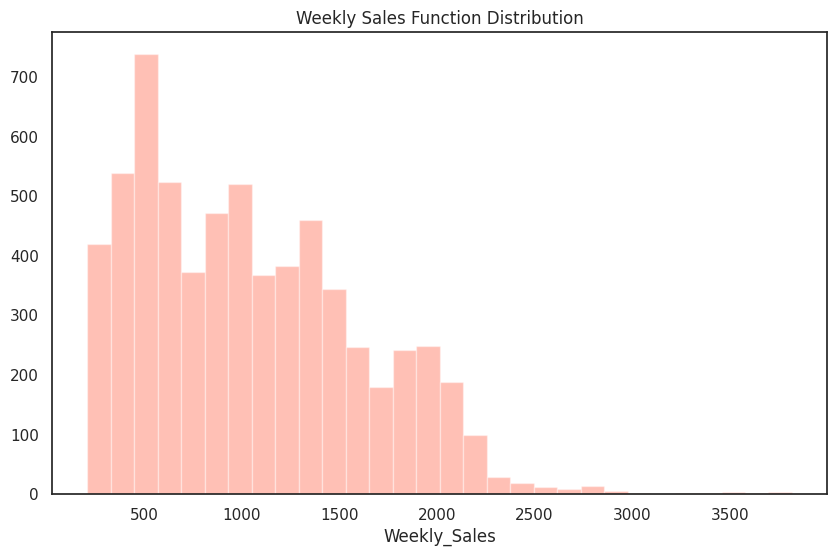

In [336]:
# From the Describe function we see that weekly sales for each store are very high.
# we will scale down the value for ease of use and revert back when we look residuals or where necessary

plt.figure(figsize=(10, 6))
data["Weekly_Sales"]=data.Weekly_Sales/1000

sns.distplot(data.Weekly_Sales, kde=False, bins=30, color = 'tomato')
plt.title('Weekly Sales Function Distribution')
plt.show()




---


In the Distribution, natural Log of Sales and the square root of Sales look better distributed


In [337]:
def scatter(dataset, column):
    plt.figure(2,4)
    plt.scatter(data[column] , data['Weekly_Sales'], color = 'turquoise')
    plt.ylabel('Weekly Sales')
    plt.xlabel(column)

In [338]:
data['Week'] = data.Date.dt.isocalendar().week

In [339]:
data.head()

,Store,Date,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Day,Month,Year,Week
0,1,2010-02-05,1643.69090,A,151315,42.31,2.572,-500.0,-500.0,-500.0,-500.0,-500.0,211.096358,8.106,0,5,Feb,2010,5
1,1,2010-02-12,1641.95744,A,151315,38.51,2.548,-500.0,-500.0,-500.0,-500.0,-500.0,211.242170,8.106,1,12,Feb,2010,6
2,1,2010-02-19,1611.96817,A,151315,39.93,2.514,-500.0,-500.0,-500.0,-500.0,-500.0,211.289143,8.106,0,19,Feb,2010,7
3,1,2010-02-26,1409.72759,A,151315,46.63,2.561,-500.0,-500.0,-500.0,-500.0,-500.0,211.319643,8.106,0,26,Feb,2010,8
4,1,2010-03-05,1554.80668,A,151315,46.50,2.625,-500.0,-500.0,-500.0,-500.0,-500.0,211.350143,8.106,0,5,Mar,2010,9


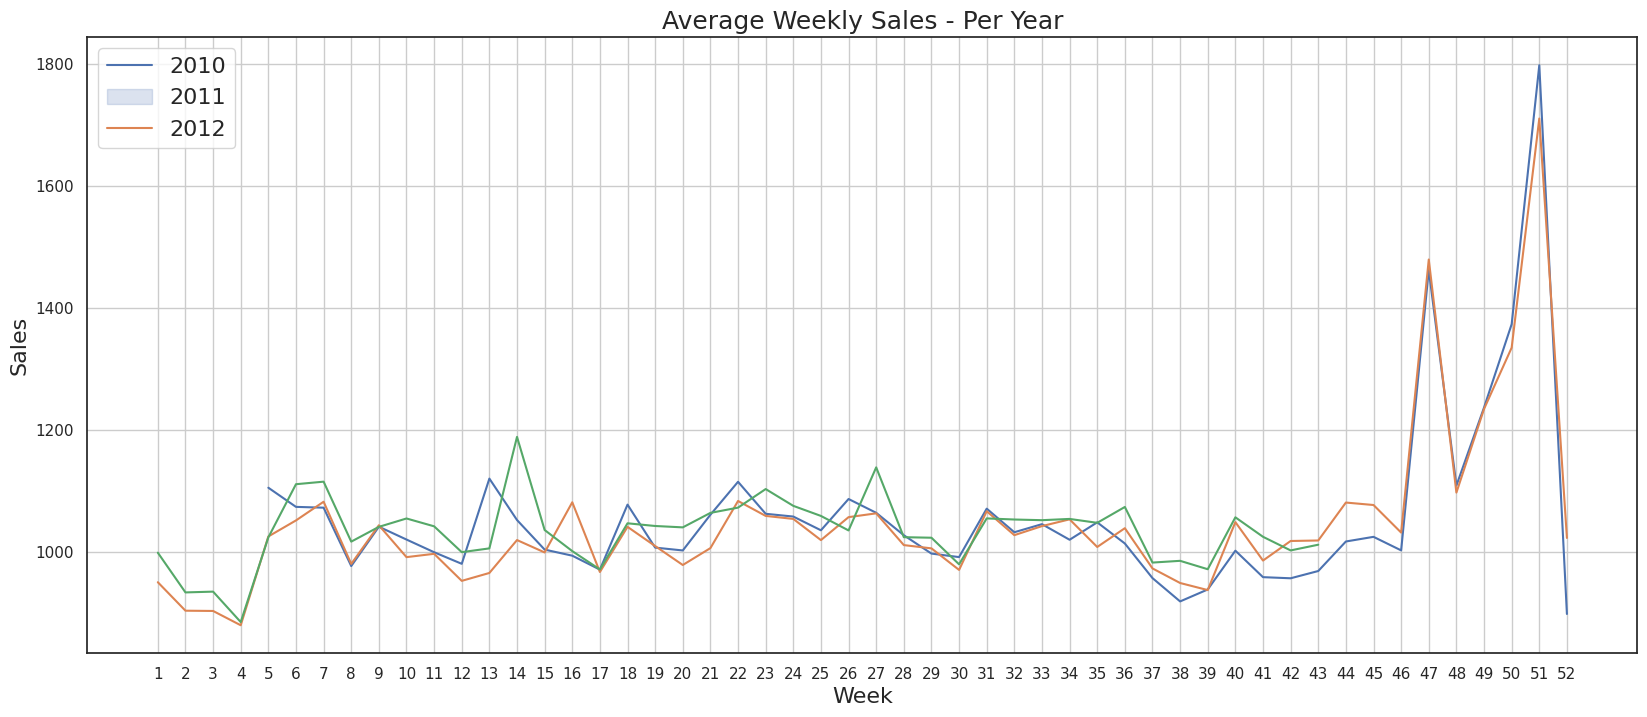

In [340]:
import matplotlib.pyplot as plt
import seaborn as sns

weekly_sales_2010 = data[data.Year==2010]['Weekly_Sales'].groupby(data['Week']).mean()
weekly_sales_2011 = data[data.Year==2011]['Weekly_Sales'].groupby(data['Week']).mean()
weekly_sales_2012 = data[data.Year==2012]['Weekly_Sales'].groupby(data['Week']).mean()

plt.figure(figsize=(20,8))

sns.lineplot(x=weekly_sales_2010.index, y=weekly_sales_2010.values)
sns.lineplot(x=weekly_sales_2011.index, y=weekly_sales_2011.values)
sns.lineplot(x=weekly_sales_2012.index, y=weekly_sales_2012.values)

plt.grid()
plt.xticks(np.arange(1, 53, step=1))
plt.legend(['2010', '2011', '2012'], loc='best', fontsize=16)
plt.title('Average Weekly Sales - Per Year', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Week', fontsize=16)
plt.show()


#### Note :

**As we can see, there is one important Holiday not included in 'IsHoliday'. It's the Easter Day. It is always in a Sunday, but can fall on different weeks.**

In 2010 is in Week 13

In 2011, Week 16

Week 14 in 2012

Week 13 in 2013 for **Test set**

**So, we can change to 'True' these Weeks in each Year.**

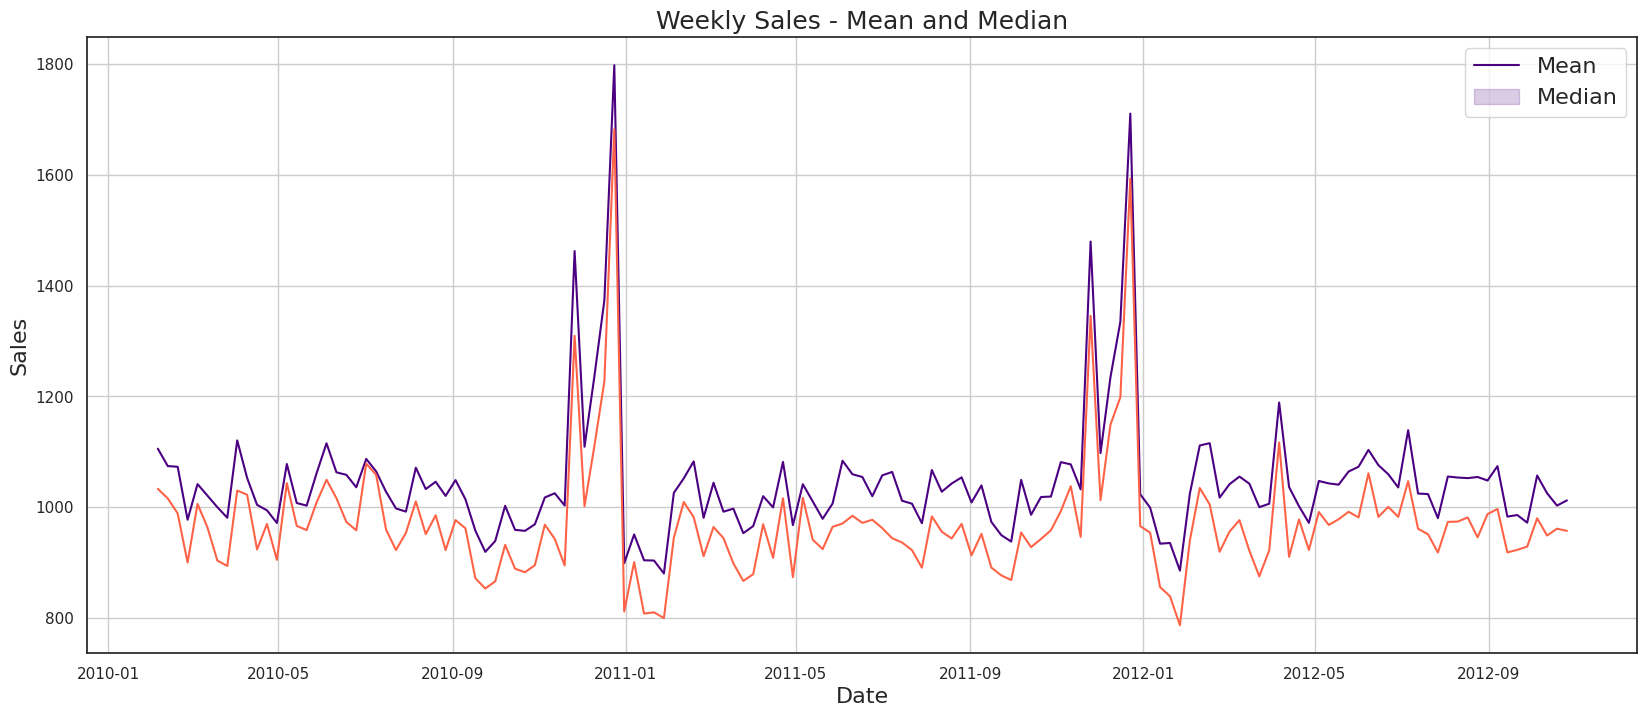

In [341]:
import matplotlib.pyplot as plt
import seaborn as sns

weekly_sales_mean = data['Weekly_Sales'].groupby(data['Date']).mean()
weekly_sales_median = data['Weekly_Sales'].groupby(data['Date']).median()

plt.figure(figsize=(20,8))

sns.lineplot(x=weekly_sales_mean.index, y=weekly_sales_mean.values, color='indigo')
sns.lineplot(x=weekly_sales_median.index, y=weekly_sales_median.values, color='tomato')

plt.grid()
plt.legend(['Mean', 'Median'], loc='best', fontsize=16)
plt.title('Weekly Sales - Mean and Median', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.show()



**<p style="background-color:white;font-family:calibri;color:lightseagreen;font-size:200%;border-radius:20px 60px;">Checking the relationship of the other features with weekly sales</p>**

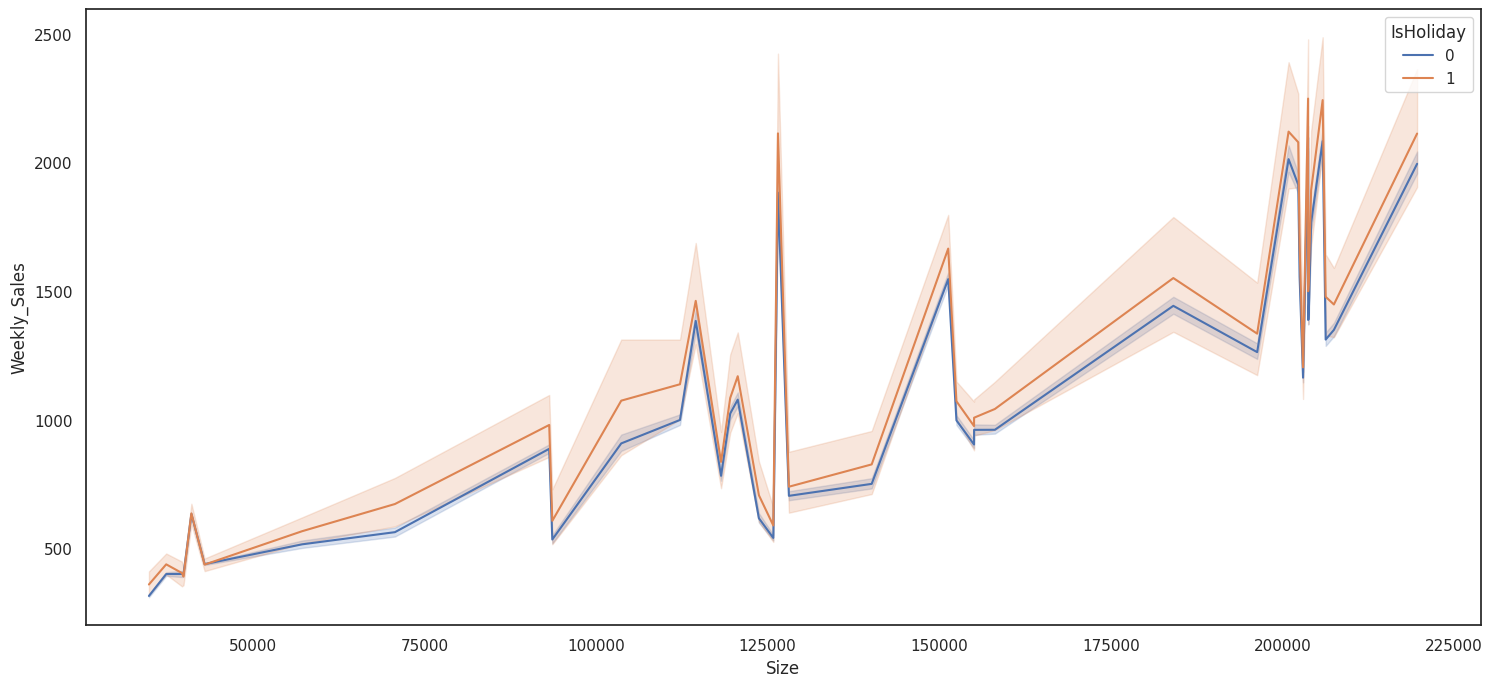

In [342]:
plt.figure(figsize=(18,8))
sns.lineplot ( data = data, x = 'Size', y =  'Weekly_Sales', hue = 'IsHoliday');

In [343]:
import plotly.express as px

px.histogram(data, x='Temperature', y ='Weekly_Sales', color='IsHoliday', marginal='box')

In [344]:
px.histogram(data, x='Fuel_Price', y ='Weekly_Sales', color='IsHoliday', marginal='box')

In [345]:
px.histogram(data, x='CPI', y ='Weekly_Sales', color='IsHoliday')

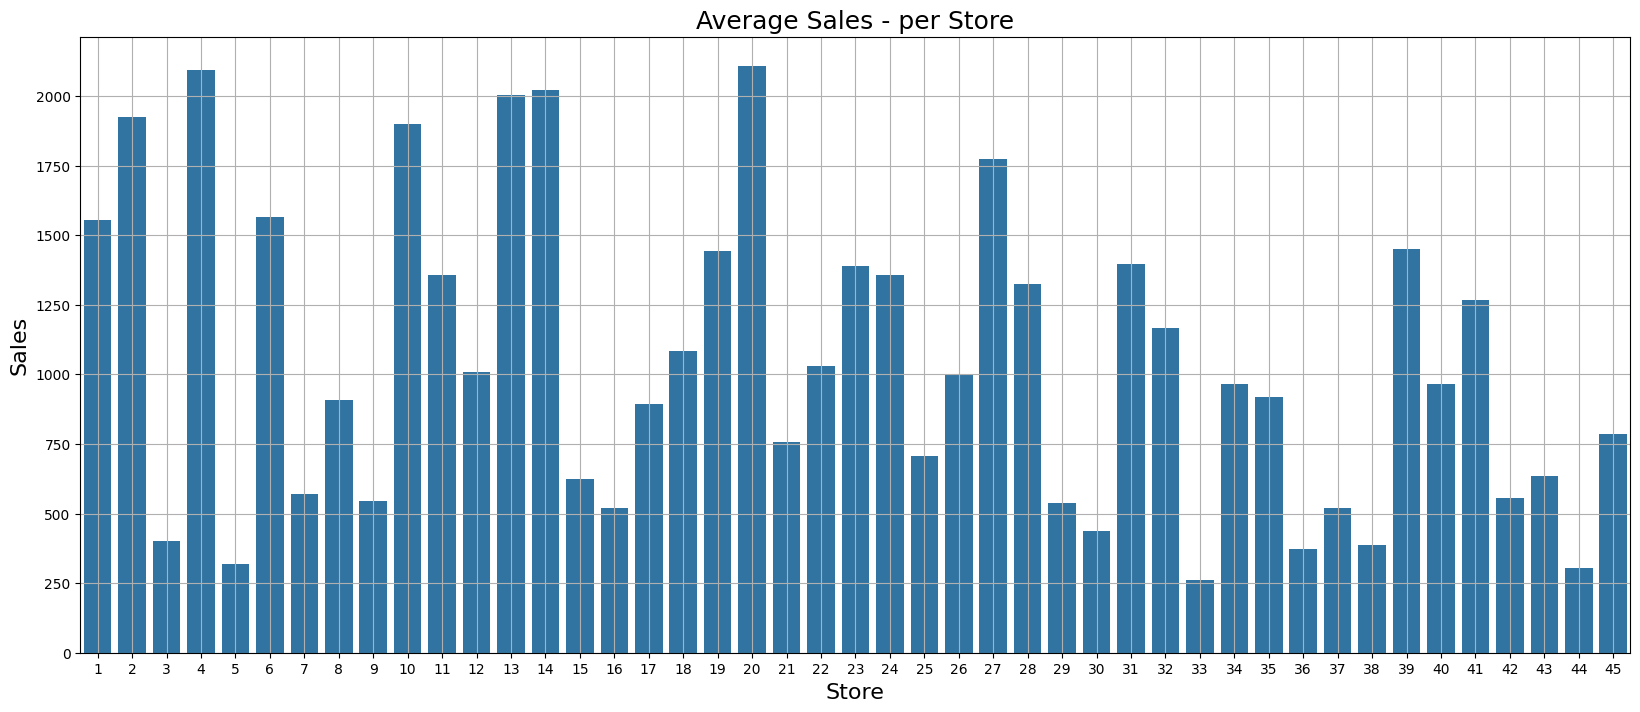

In [346]:
import seaborn as sns

weekly_sales = data['Weekly_Sales'].groupby(data['Store']).mean()
plt.figure(figsize=(20, 8))
plt.style.use('default')
sns.barplot(x=weekly_sales.index, y=weekly_sales.values)
plt.grid()
plt.title('Average Sales - per Store', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Store', fontsize=16)
plt.show()


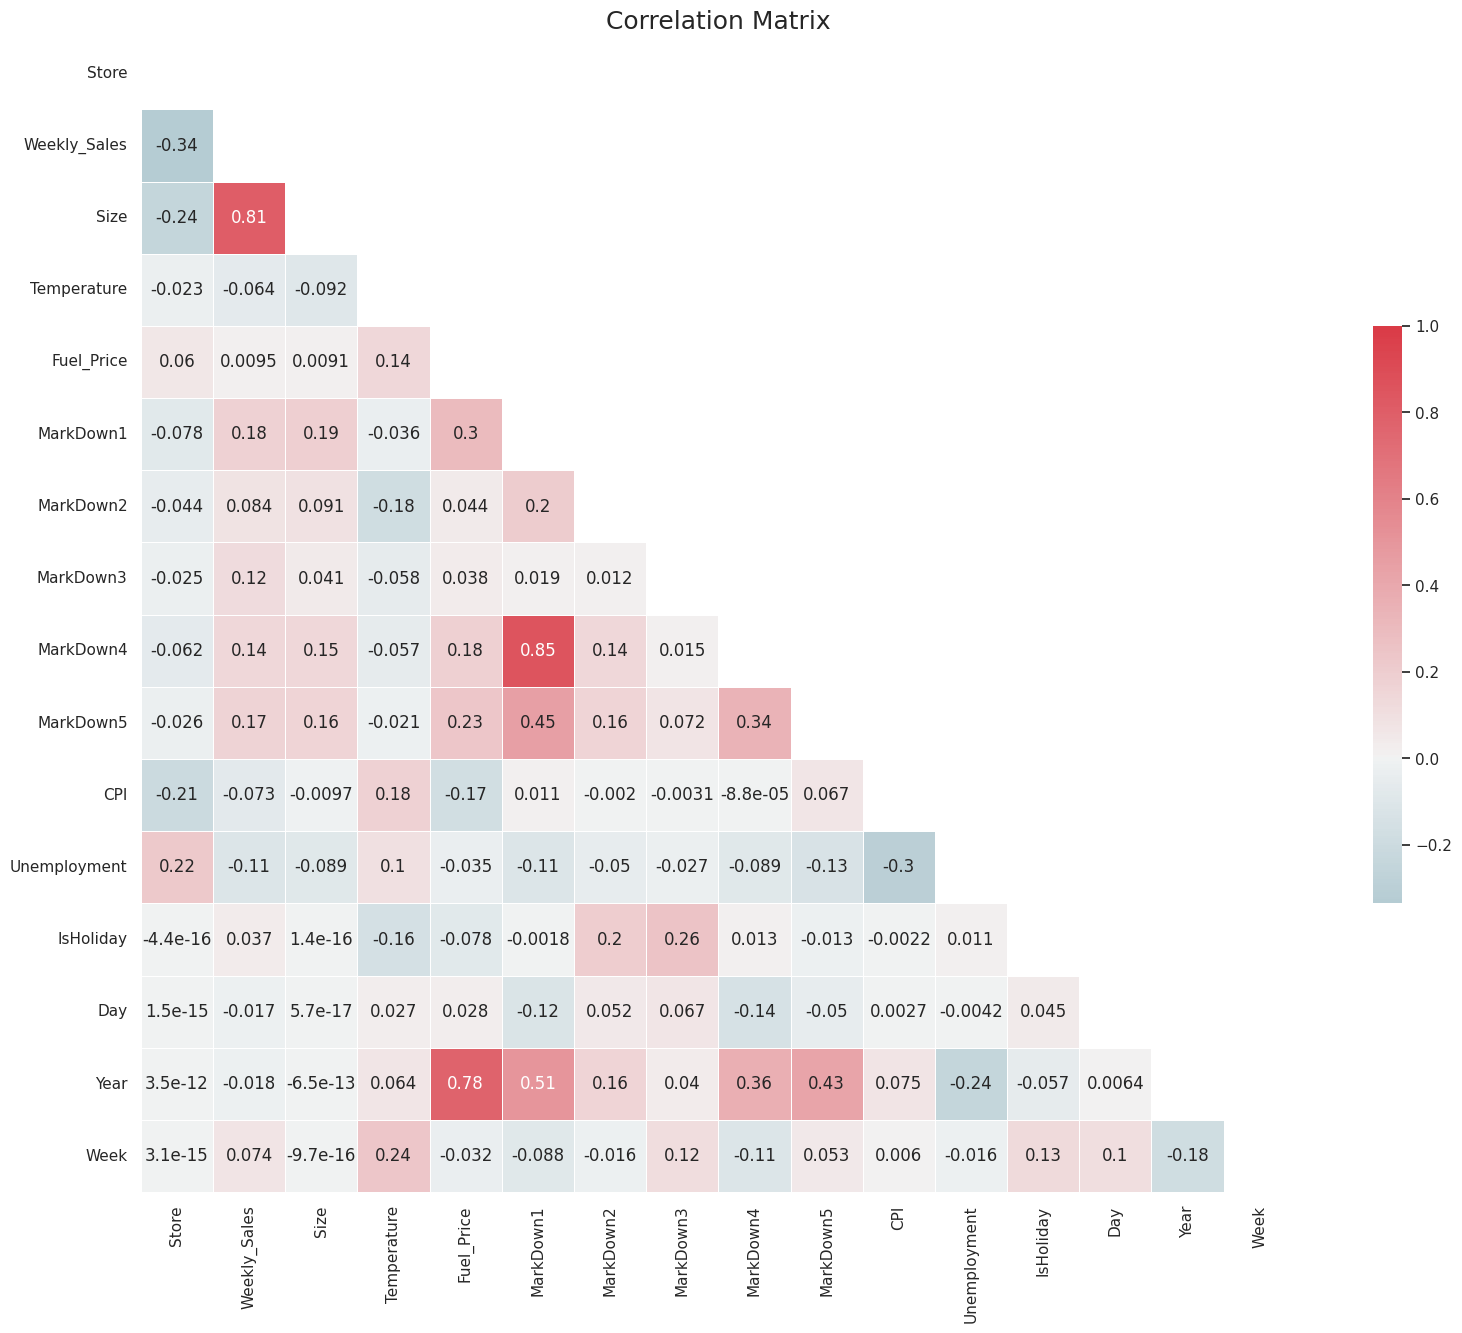

In [347]:
sns.set(style="white")

corr = data.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(20, 15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.title('Correlation Matrix', fontsize=18)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()


# <p style="background-color:coral;font-family:newtimeroman;color:white;font-size:150%;text-align:center;border-radius:20px 60px;">Modelling & Machine learning</p>

In [348]:
# create dummy variables for 'Type'
Type_dummies = pd.get_dummies(data.Type, prefix='Type')

# concatenate two DataFrames (axis=0 for rows, axis=1 for columns)
data = pd.concat([data, Type_dummies], axis=1)

# Convert dummy variables to 0 and 1
data[Type_dummies.columns] = data[Type_dummies.columns].astype(int)


In [349]:
data.columns

Index(['Store', 'Date', 'Weekly_Sales', 'Type', 'Size', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday', 'Day', 'Month', 'Year',
       'Week', 'Type_A', 'Type_B', 'Type_C'],
      dtype='object')

In [350]:
#Create a dataframe for heatmap
data_heatmap_df=data.copy()

# Eliminating all the columns that are not continuous/binary  variables from the heatmap section.
data_heatmap_df.drop(['Store','Day','Month','Year','Date','Store','Type','Type_A','Type_B','Type_C'], axis=1,inplace=True)


# Lets look the correlation matrix and heat map of the

## Correlation Heat map
def correlation_heat_map(df):
    corrs = df.corr()

    # Set the default matplotlib figure size:
    fig, ax = plt.subplots(figsize=(12,8))

    # Generate a mask for the upper triangle (taken from seaborn example gallery)
    mask = np.zeros_like(corrs, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    # Plot the heatmap with seaborn.
    # Assign the matplotlib axis the function returns. This will let us resize the labels.
    ax = sns.heatmap(corrs, mask=mask, annot=True, cmap='Pastel1_r')

    # Resize the labels.
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=90)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

    # If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
    plt.show()


<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:200%;border-radius:20px 60px;"> Statistical analysis and correlations</p>

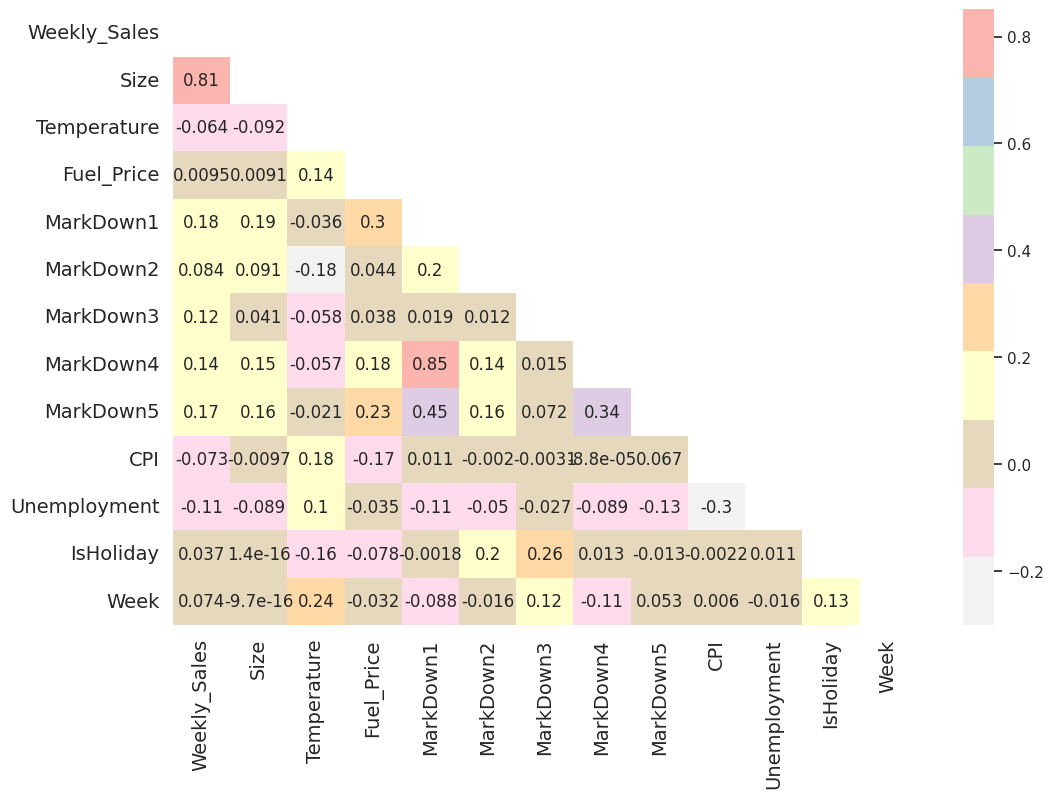

In [351]:
correlation_heat_map(data_heatmap_df)




##By checking the direct correlation of features there is no much promising correlations.There are no much correlation within the features as well. In a way this is good because there won't be multicollinearity that we have to take care while running models.


<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:200%;border-radius:20px 60px;">  Plotting data</p>

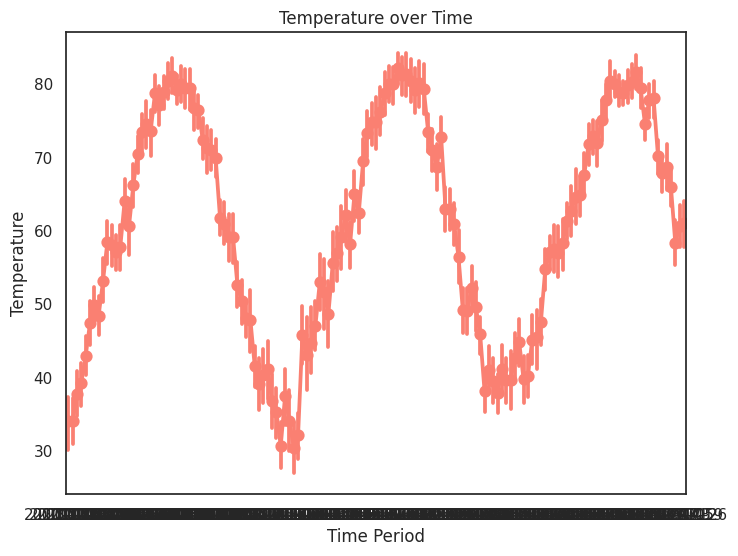

In [352]:
plt.figure(figsize=(8,6))
sns.pointplot(x="Date", y="Temperature", data=data, color = 'salmon')
plt.xlabel('Time Period')
plt.ylabel('Temperature')
plt.title('Temperature over Time')
plt.show()
# inference: Graph clearly shows Temperature is more of a seasonal and repeated in cycles and this would
# be an interesting data point that we can use for studies further

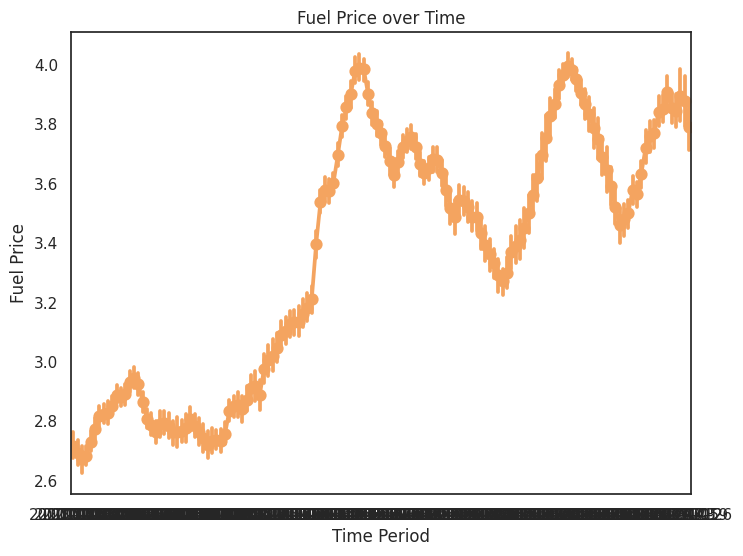

In [353]:
plt.figure(figsize=(8,6))
sns.pointplot(x="Date", y="Fuel_Price", data=data, color = 'sandybrown')
plt.xlabel('Time Period')
plt.ylabel('Fuel Price')
plt.title('Fuel Price over Time')
plt.show()
# inference: Fuel price varies over time and there are high and lows

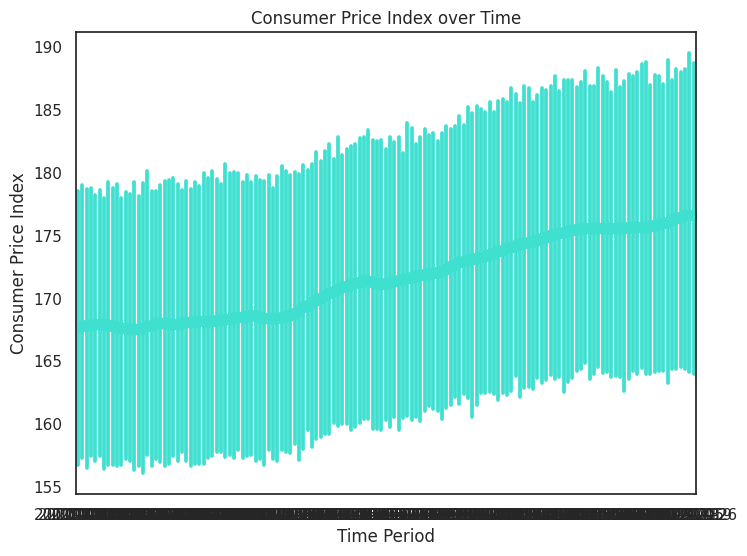

In [354]:
plt.figure(figsize=(8,6))
sns.pointplot(x="Date", y="CPI", data=data, color = 'turquoise')
plt.xlabel('Time Period')
plt.ylabel('Consumer Price Index')
plt.title('Consumer Price Index over Time')
plt.show()
# inference: over time CPI have increased. but the change is not much

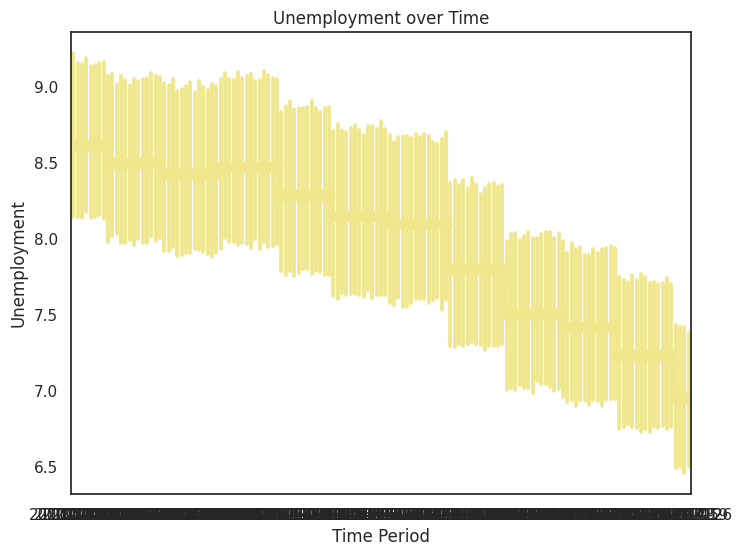

In [355]:
plt.figure(figsize=(8,6))
sns.pointplot(x="Date", y="Unemployment", data=data, color='khaki')
plt.xlabel('Time Period')
plt.ylabel('Unemployment')
plt.title('Unemployment over Time')
plt.show()
# inference:  Over time unemployment have came down we can see this factor also whether it have affected the Sales


**Features over time changes quite a bit. We will see whether these have any effects on Sales while we model**

We know that **Markdown columns have quiet few outliers** it can be because of our imputation as well. So we will treate them later and try implement a better way of imputation. Eg: KNN imputation, Random value between min and max imputation..

**Weekly Sales also seem to have some Outliers but we will keep them as it is for now as they may indicate crucial information.**



<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:200%;border-radius:20px 60px;"> Visual analysis</p>

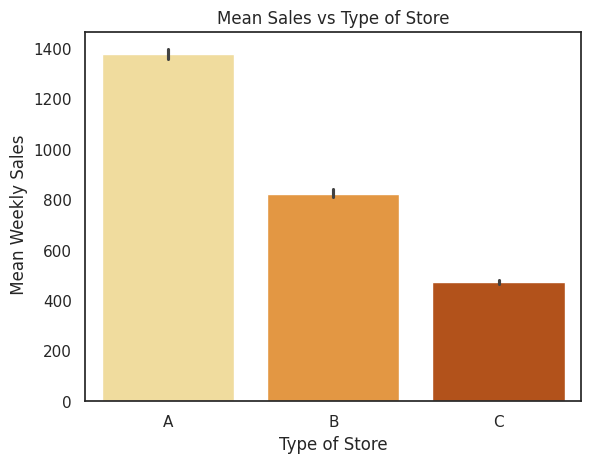

In [356]:
# Checking how the Type of the store have effect on the sales.
col=['coral', 'greenyellow', 'turquoise']
sns.barplot(x="Type", y="Weekly_Sales", data=data,orient='v', palette ='YlOrBr')
plt.xlabel('Type of Store')
plt.ylabel(' Mean Weekly Sales')
plt.title('Mean Sales vs Type of Store')
#plt.savefig('./images/Type_vs_Sales.png')
plt.show()

# inference: From the graph its clear that Type A > Type B > Type C in mean weekly sales.

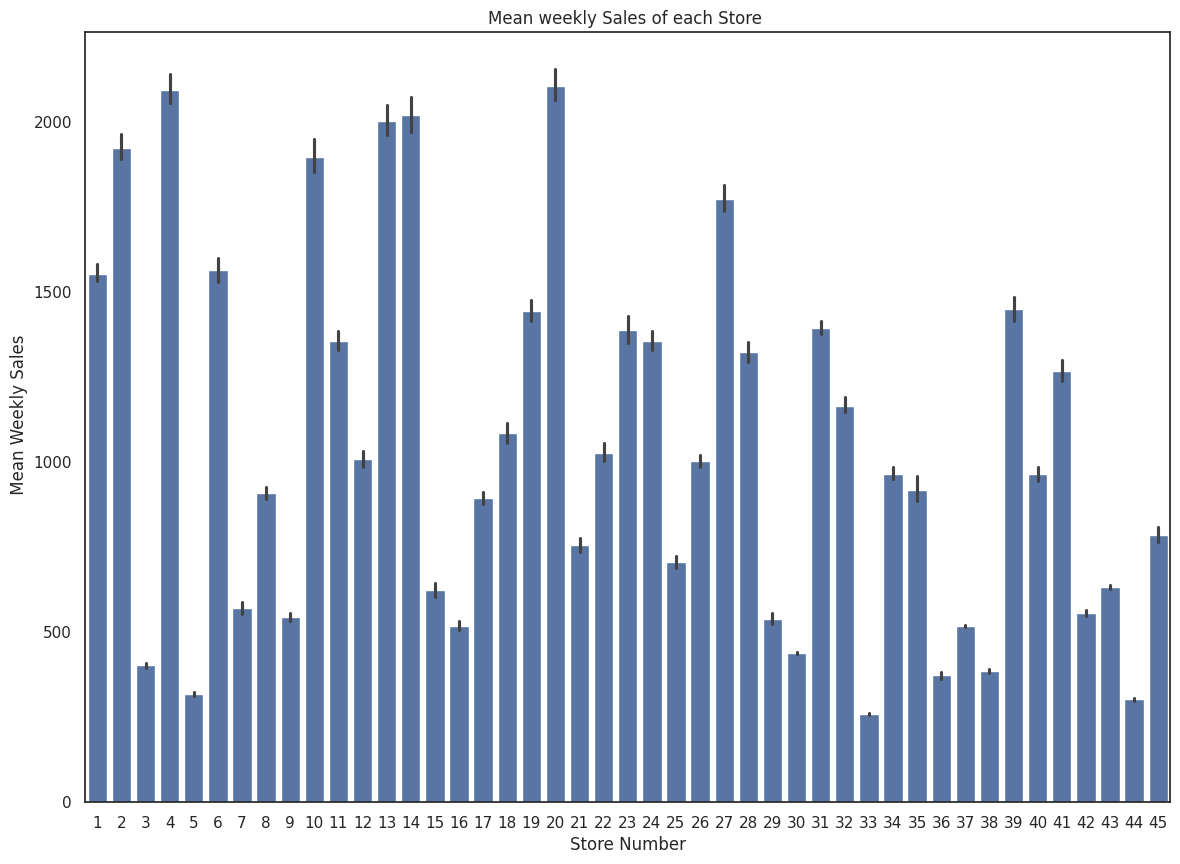

In [357]:
plt.subplots(figsize=(14,10))
sns.barplot(x="Store", y="Weekly_Sales", data=data,orient='v')
plt.xlabel('Store Number')
plt.ylabel(' Mean Weekly Sales')
plt.title('Mean weekly Sales of each Store ')
#plt.savefig('./images/Mean_Weekly_Sales_vs_Stores.png')
plt.show()

# inference : From the chart we can see that there are stores that have a weekly sales from $250,000
#             to $2,200,000

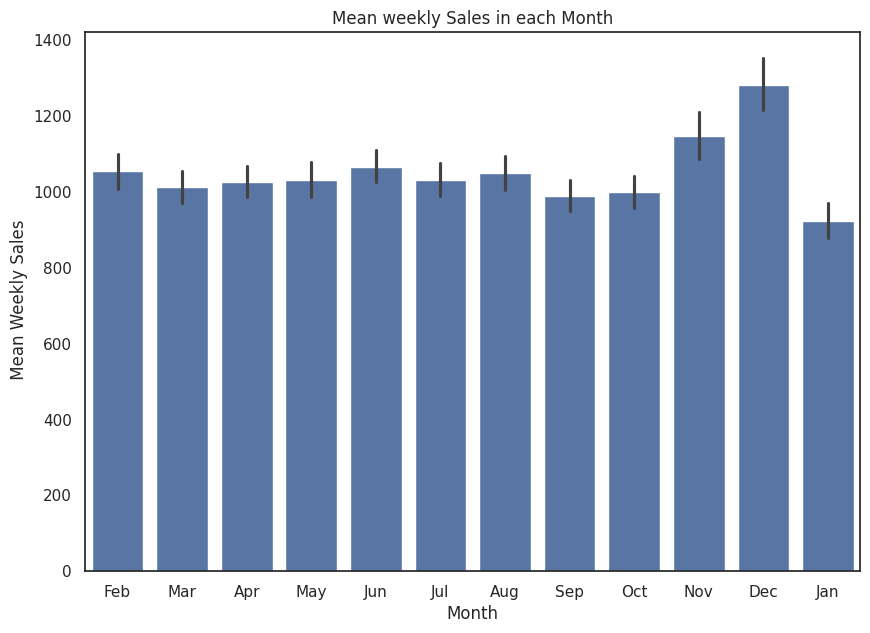

In [358]:
plt.subplots(figsize=(10,7))
sns.barplot(x="Month", y="Weekly_Sales", data=data,orient='v')
plt.xlabel('Month')
plt.ylabel(' Mean Weekly Sales')
plt.title('Mean weekly Sales in each Month')
plt.show()
# inference: Graph shows sales in each month and from this we can see December seems to have a very high sales
#            compared to every other month and January have the least sales.

#### With this we come to an end of EDA . We will now move forward with Machine Learning & Modelling


<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:230%;border-radius:20px 60px;"> Feature Engineering </p>

#### Before creating and running model we will look through the columns and make meaningful columns and create dummies where needed.

**We need to take special care (KNN Imputation) of Markdown5 which has many outlier and as we know Markdown1-5 which have a lot of missing values.**

We will create dummies for **"Store, Month, Year"**



In [359]:
# Create Week column which says which week of the month it is.
data["Week"]= round(np.floor(((data.Day-1)/7)+1))

# Create dummies for the columns that are required for later studies
Store_dummies = pd.get_dummies(data.Store, prefix='Store')
Month_dummies = pd.get_dummies(data.Month, prefix='Month')
Year_dummies = pd.get_dummies(data.Year, prefix='Year')
Week_dummies = pd.get_dummies(data.Week, prefix='Week')

# concatenate DataFrames (axis=0 for rows, axis=1 for columns)
data = pd.concat([data, Store_dummies,Month_dummies,Year_dummies,Week_dummies], axis=1)

In [360]:
data

,Store,Date,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Month_Oct,Month_Sep,Year_2010,Year_2011,Year_2012,Week_1.0,Week_2.0,Week_3.0,Week_4.0,Week_5.0
0,1,2010-02-05,1643.69090,A,151315,42.31,2.572,-500.00,-500.00,-500.00,...,False,False,True,False,False,True,False,False,False,False
1,1,2010-02-12,1641.95744,A,151315,38.51,2.548,-500.00,-500.00,-500.00,...,False,False,True,False,False,False,True,False,False,False
2,1,2010-02-19,1611.96817,A,151315,39.93,2.514,-500.00,-500.00,-500.00,...,False,False,True,False,False,False,False,True,False,False
3,1,2010-02-26,1409.72759,A,151315,46.63,2.561,-500.00,-500.00,-500.00,...,False,False,True,False,False,False,False,False,True,False
4,1,2010-03-05,1554.80668,A,151315,46.50,2.625,-500.00,-500.00,-500.00,...,False,False,True,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,713.17395,B,118221,64.88,3.997,4556.61,20.64,1.50,...,False,True,False,False,True,False,False,False,True,False
6431,45,2012-10-05,733.45507,B,118221,64.89,3.985,5046.74,-500.00,18.82,...,True,False,False,False,True,True,False,False,False,False
6432,45,2012-10-12,734.46436,B,118221,54.47,4.000,1956.28,-500.00,7.89,...,True,False,False,False,True,False,True,False,False,False
6433,45,2012-10-19,718.12553,B,118221,56.47,3.969,2004.02,-500.00,3.18,...,True,False,False,False,True,False,False,True,False,False


In [361]:
data_decision=data.iloc[:,:18]

data_decision["Week"]= round(np.floor(((data_decision.Day-1)/7)+1))

In [362]:
# Drop the columns that we have created dummies
data.drop(['Type', 'Store','Month','Year','Day','Week'], axis=1, inplace=True)

In [363]:
# drop each column from the list of dummies to make it perfect to use in models
data.drop(['Type_C', 'Store_1','Month_Jan','Year_2010','Week_5.0'], axis=1, inplace=True)

In [364]:
data

,Date,Weekly_Sales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,Month_May,Month_Nov,Month_Oct,Month_Sep,Year_2011,Year_2012,Week_1.0,Week_2.0,Week_3.0,Week_4.0
0,2010-02-05,1643.69090,151315,42.31,2.572,-500.00,-500.00,-500.00,-500.00,-500.00,...,False,False,False,False,False,False,True,False,False,False
1,2010-02-12,1641.95744,151315,38.51,2.548,-500.00,-500.00,-500.00,-500.00,-500.00,...,False,False,False,False,False,False,False,True,False,False
2,2010-02-19,1611.96817,151315,39.93,2.514,-500.00,-500.00,-500.00,-500.00,-500.00,...,False,False,False,False,False,False,False,False,True,False
3,2010-02-26,1409.72759,151315,46.63,2.561,-500.00,-500.00,-500.00,-500.00,-500.00,...,False,False,False,False,False,False,False,False,False,True
4,2010-03-05,1554.80668,151315,46.50,2.625,-500.00,-500.00,-500.00,-500.00,-500.00,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,2012-09-28,713.17395,118221,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,...,False,False,False,True,False,True,False,False,False,True
6431,2012-10-05,733.45507,118221,64.89,3.985,5046.74,-500.00,18.82,2253.43,2340.01,...,False,False,True,False,False,True,True,False,False,False
6432,2012-10-12,734.46436,118221,54.47,4.000,1956.28,-500.00,7.89,599.32,3990.54,...,False,False,True,False,False,True,False,True,False,False
6433,2012-10-19,718.12553,118221,56.47,3.969,2004.02,-500.00,3.18,437.73,1537.49,...,False,False,True,False,False,True,False,False,True,False




Next, we will perform **KNN (K Nearest Neighbours) imputation for Markdown columns**.

    


<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:200%;border-radius:20px 60px;">  KNN model imputation </p>


###treating the Markdown columns

In [365]:
data.iloc[:,5:10].describe().T


,count,mean,std,min,25%,50%,75%,max
MarkDown1,6435.0,2106.175500,6008.334618,-500.0,-500.0,-500.0,2302.300,88646.76
MarkDown2,6435.0,446.067837,4946.234382,-500.0,-500.0,-500.0,0.090,104519.54
MarkDown3,6435.0,88.158396,5306.320800,-500.0,-500.0,-500.0,3.705,141630.61
MarkDown4,6435.0,661.551088,3853.055534,-500.0,-500.0,-500.0,314.320,67474.85
MarkDown5,6435.0,1260.128491,4227.342723,-500.0,-500.0,-500.0,1983.265,108519.28


In [366]:
data.MarkDown1=data.MarkDown1.map(lambda x: np.nan if x==-500 else x)
data.MarkDown2=data.MarkDown2.map(lambda x: np.nan if x==-500 else x)
data.MarkDown3=data.MarkDown3.map(lambda x: np.nan if x==-500 else x)
data.MarkDown4=data.MarkDown4.map(lambda x: np.nan if x==-500 else x)
data.MarkDown5=data.MarkDown5.map(lambda x: np.nan if x==-500 else x)

In [367]:
missing_cols = ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']

# Not including our actual y(Weekly Sales) and Size of store for Markdown since by including weekly sales
# It can be a bad method to use those MarkDown again for predicting weekly sales.

impute_cols = [c for c in data.columns if not c in ['Weekly_Sales','Date','Sqrt_Sales','lnSales']+missing_cols]

data_imputed=data.copy()


In [368]:
def find_best_k_reg(X, y, k_min=1, k_max=51, step=2, cv=10):
    k_range = range(k_min, k_max+1, step)
    r2s = []
    for k in k_range:
        knn = KNeighborsRegressor(n_neighbors=k)
        scores = cross_val_score(knn, X, y, cv=cv)
        r2s.append(np.mean(scores))
    print ("Best R2 value:",np.max(r2s),"\nBest k: ",np.argmax(k_range))
    return np.argmax(k_range)

In [369]:
impute_missing = data.loc[data.MarkDown1.isnull(), :]
impute_valid = data.loc[~data.MarkDown1.isnull(), :]

y = impute_valid.MarkDown1.values
X = impute_valid[impute_cols]

Xs = ss.fit_transform(X)

Best R2 value: 0.14140639091506765 
Best k:  25


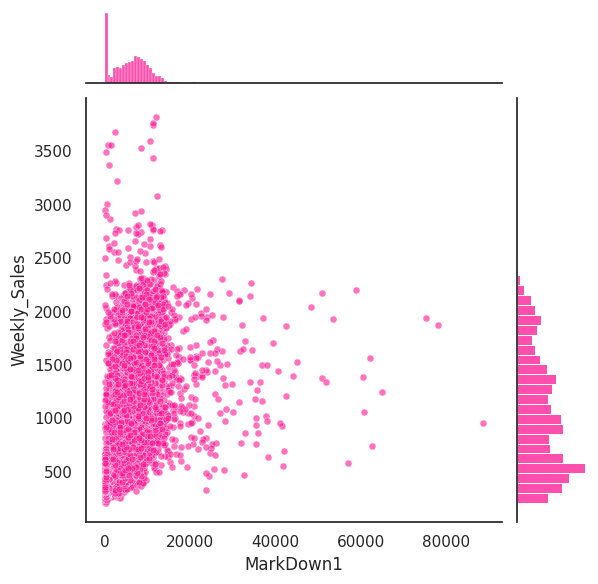

In [370]:
best_k = find_best_k_reg(Xs, y)
knn = KNeighborsRegressor(n_neighbors=best_k)
knn.fit(Xs, y)

X_miss = impute_missing[impute_cols]
X_miss_s = ss.transform(X_miss)

MarkDown1_impute = knn.predict(X_miss_s)

data_imputed.loc[data.MarkDown1.isnull(), 'MarkDown1'] = MarkDown1_impute


# Plotting the jointplot with the specified data
sns.jointplot(data=data_imputed, x='MarkDown1', y='Weekly_Sales', joint_kws=dict(s=25, alpha=0.6), color='deeppink')
plt.show()


Best R2 value: 0.41503402148479146 
Best k:  25


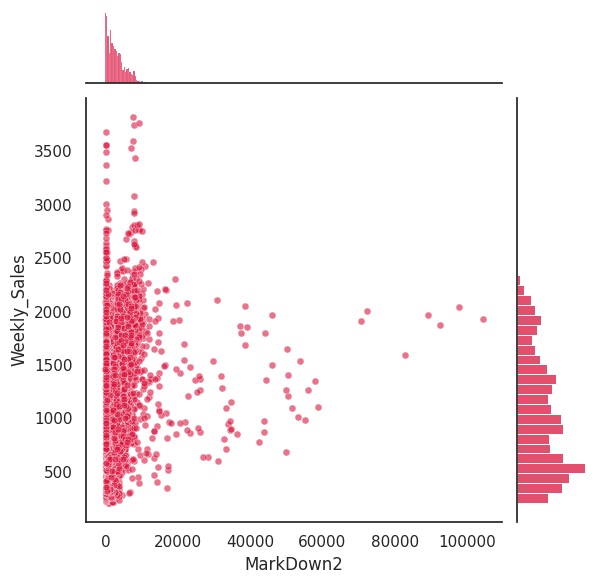

In [371]:
impute_missing = data.loc[data.MarkDown2.isnull(), :]
impute_valid = data.loc[~data.MarkDown2.isnull(), :]

y = impute_valid.MarkDown2.values
X = impute_valid[impute_cols]

ss = StandardScaler()
Xs = ss.fit_transform(X)
best_k = find_best_k_reg(Xs, y)
knn = KNeighborsRegressor(n_neighbors=best_k)
knn.fit(Xs, y)

X_miss = impute_missing[impute_cols]
X_miss_s = ss.transform(X_miss)

MarkDown2_impute = knn.predict(X_miss_s)

data_imputed.loc[data.MarkDown2.isnull(), 'MarkDown2'] = MarkDown2_impute

# Plotting the jointplot with the specified data and column names
sns.jointplot(data=data_imputed, x='MarkDown2', y='Weekly_Sales', joint_kws=dict(s=25, alpha=0.6), color='crimson')
plt.show()


Best R2 value: 0.20431863554303203 
Best k:  25


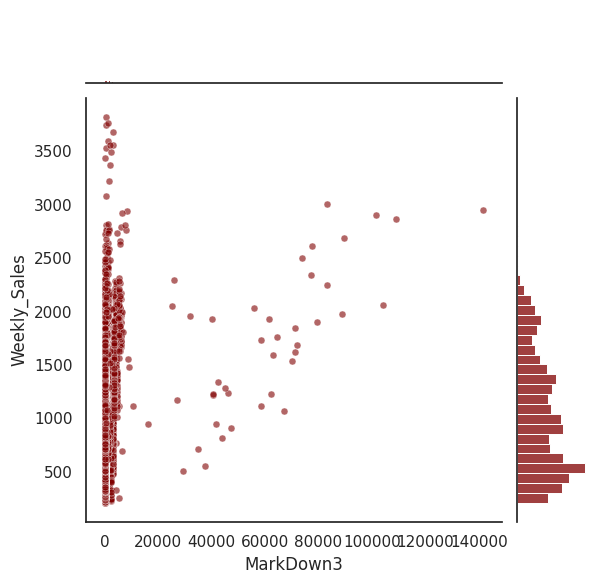

In [372]:
impute_missing = data.loc[data.MarkDown3.isnull(), :]
impute_valid = data.loc[~data.MarkDown3.isnull(), :]

y = impute_valid.MarkDown3.values
X = impute_valid[impute_cols]

ss = StandardScaler()
Xs = ss.fit_transform(X)
best_k = find_best_k_reg(Xs, y)
knn = KNeighborsRegressor(n_neighbors=best_k)
knn.fit(Xs, y)

X_miss = impute_missing[impute_cols]
X_miss_s = ss.transform(X_miss)

MarkDown3_impute = knn.predict(X_miss_s)

data_imputed.loc[data.MarkDown3.isnull(), 'MarkDown3'] = MarkDown3_impute
sns.jointplot(data=data_imputed, x='MarkDown3', y='Weekly_Sales', joint_kws=dict(s=25, alpha=0.6), color='maroon')
plt.show()

Best R2 value: 0.3470822603116795 
Best k:  25


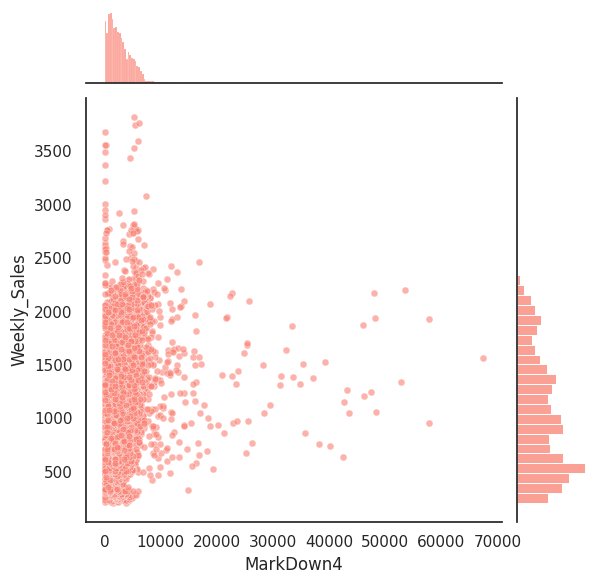

In [373]:
impute_missing = data.loc[data.MarkDown4.isnull(), :]
impute_valid = data.loc[~data.MarkDown4.isnull(), :]

y = impute_valid.MarkDown4.values
X = impute_valid[impute_cols]

ss = StandardScaler()
Xs = ss.fit_transform(X)
best_k = find_best_k_reg(Xs, y)
knn = KNeighborsRegressor(n_neighbors=best_k)
knn.fit(Xs, y)

X_miss = impute_missing[impute_cols]
X_miss_s = ss.transform(X_miss)

MarkDown4_impute = knn.predict(X_miss_s)

data_imputed.loc[data.MarkDown4.isnull(), 'MarkDown4'] = MarkDown4_impute

sns.jointplot(data=data_imputed, x='MarkDown4', y='Weekly_Sales', joint_kws=dict(s=25, alpha=0.6), color='salmon')
plt.show()

Best R2 value: 0.0815206539204145 
Best k:  25


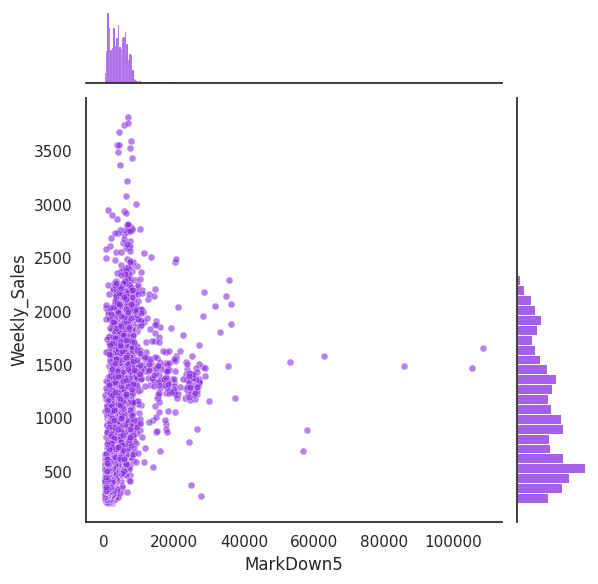

In [374]:
impute_missing = data.loc[data.MarkDown5.isnull(), :]
impute_valid = data.loc[~data.MarkDown5.isnull(), :]

y = impute_valid.MarkDown5.values
X = impute_valid[impute_cols]

ss = StandardScaler()
Xs = ss.fit_transform(X)
best_k = find_best_k_reg(Xs, y)
knn = KNeighborsRegressor(n_neighbors=best_k)
knn.fit(Xs, y)

X_miss = impute_missing[impute_cols]
X_miss_s = ss.transform(X_miss)

MarkDown5_impute = knn.predict(X_miss_s)

data_imputed.loc[data.MarkDown5.isnull(), 'MarkDown5'] = MarkDown5_impute

sns.jointplot(data=data_imputed, x='MarkDown5', y='Weekly_Sales', joint_kws=dict(s=25, alpha=0.6), color='blueviolet')
plt.show()

In [375]:
data

,Date,Weekly_Sales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,Month_May,Month_Nov,Month_Oct,Month_Sep,Year_2011,Year_2012,Week_1.0,Week_2.0,Week_3.0,Week_4.0
0,2010-02-05,1643.69090,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,True,False,False,False
1,2010-02-12,1641.95744,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,True,False,False
2,2010-02-19,1611.96817,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,True,False
3,2010-02-26,1409.72759,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,True
4,2010-03-05,1554.80668,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,2012-09-28,713.17395,118221,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,...,False,False,False,True,False,True,False,False,False,True
6431,2012-10-05,733.45507,118221,64.89,3.985,5046.74,NaN,18.82,2253.43,2340.01,...,False,False,True,False,False,True,True,False,False,False
6432,2012-10-12,734.46436,118221,54.47,4.000,1956.28,NaN,7.89,599.32,3990.54,...,False,False,True,False,False,True,False,True,False,False
6433,2012-10-19,718.12553,118221,56.47,3.969,2004.02,NaN,3.18,437.73,1537.49,...,False,False,True,False,False,True,False,False,True,False


In [376]:
walmart_data=data_imputed.copy()

# The accuracy and R2 are very bad. This means that we likely imputing crap with these models.
# This doesn't necessarily mean that imputation is a bad idea, but we may want to consider
# using a different method.

So finally we have replaced all missing values in **MarkDown1-5** with **KNN imputation** from the given value range itself. We will see the performance of the model and see through whether we have any better methods. As of now my assumption is KNN imputation values would work because thats the best way we have.

**Lets Try Linear Regression for predicting Weekly_Sales with and without the imputed values and see whether its better to keep the imputed MarkDown Values**


<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:220%;border-radius:20px 60px;">  Modelling </p>


0.9443437182485424
0.9441790012821523
Adjusted R^2 0.9436961451589814
Cross-validated scores: [0.93344572 0.93544613 0.9326906  0.95307222 0.93291241 0.94872683
 0.94881628 0.95832437 0.93823496 0.93840451]
Mean Cross validation 0.94200740203963


Text(0.5, 1.0, 'Predicted vs Actual Sales')

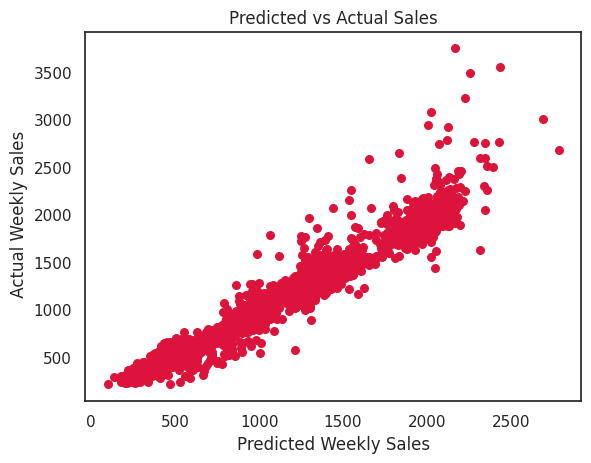

In [377]:
predictors=[col for col in data_imputed.columns if col not in ['Date','Weekly_Sales']]
X=data_imputed[predictors]
y=data_imputed.Weekly_Sales.values

Xs = ss.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.33)

mlr = LinearRegression()
mlr.fit(X_train, y_train)
r2=mlr.score(X_test, y_test)
print(mlr.score(X_test, y_test))
print(mlr.score(X_train, y_train))
adj_r2 = 1 - (len(y)-1)/(len(y)-X.shape[1]-1)*(1-r2)
print("Adjusted R^2",adj_r2)


# Perform 10-fold cross validation
scores = cross_val_score(mlr, X_train, y_train, cv=10)
print ("Cross-validated scores:", scores)
print ("Mean Cross validation",scores.mean())



# Make cross validated predictions on the test sets
predictions = cross_val_predict(mlr, X_test, y_test, cv=10)

plt.scatter(predictions, y_test, s=30, c='crimson', zorder=10)
plt.xlabel('Predicted Weekly Sales')
plt.ylabel(' Actual Weekly Sales')
plt.title('Predicted vs Actual Sales')

**Now let us look the same model without MarkDowns to check whether data with MarkDown or without MarkDown is good.**

0.9304904484581316
0.9416450616519838
Cross-validated scores: [ 7.00623667e-01 -1.08697646e+14 -2.19597313e+13 -2.06841105e+13
 -9.48465137e+12 -1.43608182e+14 -3.87166639e+12 -8.41748193e+13
 -8.84649453e+11 -8.01786741e+13]
Mean Cross validation -47354413069712.734


Text(0.5, 1.0, 'Predicted vs Actual Sales')

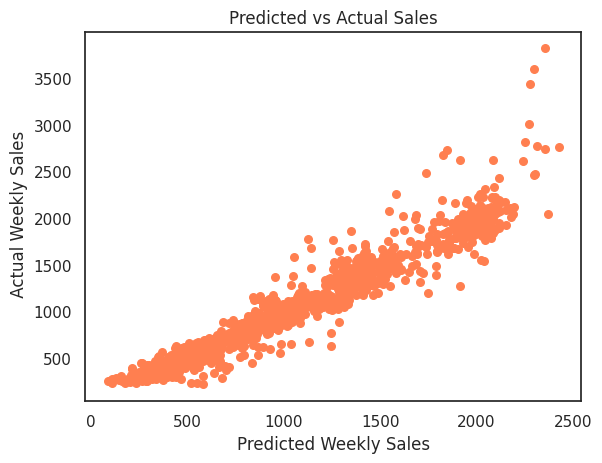

In [378]:
predictors=[col for col in data.columns if col not in ['Date','Weekly_Sales']]
predictors=[col for col in predictors if 'MarkDown' not in col]
X=data[predictors]
y=data.Weekly_Sales.values
Xs = ss.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.2)

lr = LinearRegression()
lr.fit(X_train, y_train)

print(lr.score(X_test, y_test))
print(lr.score(X_train, y_train))


# Perform 10-fold cross validation
scores = cross_val_score(lr, X, y, cv=10)
print ("Cross-validated scores:", scores)
print ("Mean Cross validation",scores.mean())



# Make cross validated predictions on the test sets
predictions = cross_val_predict(lr, X_test, y_test, cv=10)

plt.scatter(predictions, y_test, s=30, color = 'coral', zorder=10)
plt.xlabel('Predicted Weekly Sales')
plt.ylabel(' Actual Weekly Sales')
plt.title('Predicted vs Actual Sales')

#### From the Cross validation its clear that the one with Markdown values are better than they are dropped.

So we will keep MarkDowns as of now and **assume** the KNN model have imputed the correct values.
Now lets move on to real **Modeling** for the prediction of Weekly_sales

We have seen that normal running of Linear regression is a very bad idea. Even though it gives a high R2 value the cross validated score doesn't make any sense. Now its time to go on with **feature selection**


In [379]:
data=data_imputed.copy()

**We will divide our train and test datasets first and then deal with that seperately**

In [380]:
# Setting the offset to finalize the test data.
offset = timedelta(days=90)
split_date=data.Date.max()-offset
split_date

Timestamp('2012-07-28 00:00:00')

In [381]:
data_train=data[data.Date < split_date]
data_test=data[data.Date > split_date]

In [382]:
data_train = data_train.reindex(np.random.permutation(data_imputed.index))## Identify outliers

In [383]:
data_train.columns

Index(['Date', 'Weekly_Sales', 'Size', 'Temperature', 'Fuel_Price',
       'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI',
       'Unemployment', 'IsHoliday', 'Type_A', 'Type_B', 'Store_2', 'Store_3',
       'Store_4', 'Store_5', 'Store_6', 'Store_7', 'Store_8', 'Store_9',
       'Store_10', 'Store_11', 'Store_12', 'Store_13', 'Store_14', 'Store_15',
       'Store_16', 'Store_17', 'Store_18', 'Store_19', 'Store_20', 'Store_21',
       'Store_22', 'Store_23', 'Store_24', 'Store_25', 'Store_26', 'Store_27',
       'Store_28', 'Store_29', 'Store_30', 'Store_31', 'Store_32', 'Store_33',
       'Store_34', 'Store_35', 'Store_36', 'Store_37', 'Store_38', 'Store_39',
       'Store_40', 'Store_41', 'Store_42', 'Store_43', 'Store_44', 'Store_45',
       'Month_Apr', 'Month_Aug', 'Month_Dec', 'Month_Feb', 'Month_Jul',
       'Month_Jun', 'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct',
       'Month_Sep', 'Year_2011', 'Year_2012', 'Week_1.0', 'Week_2.0',
       'Week_3

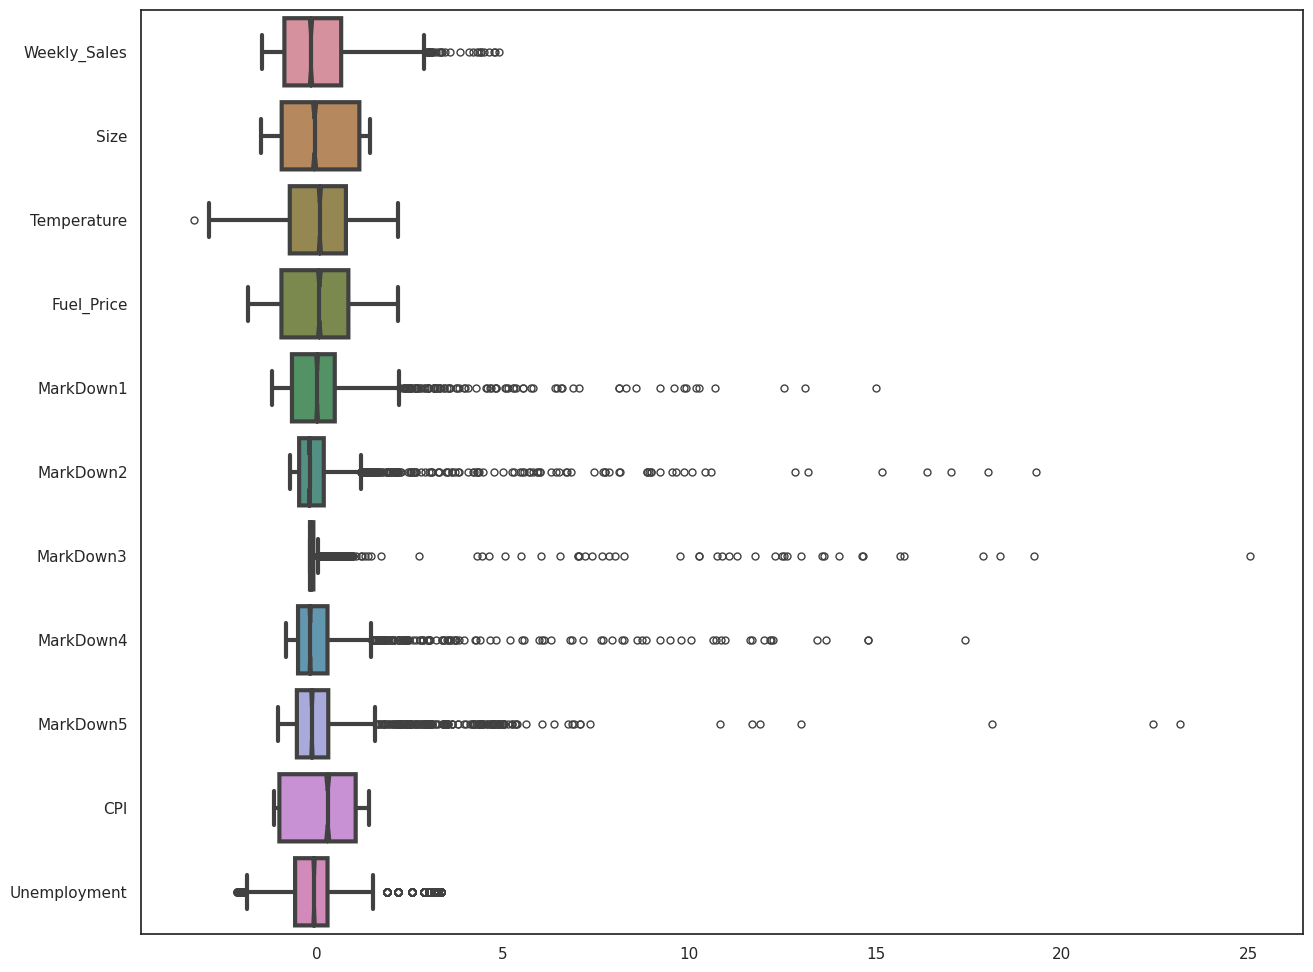

In [384]:
data_box=data_train.iloc[:, 1:12]
data_norm = (data_box - data_box.mean()) / data_box.std()

fig = plt.figure(figsize=(15, 12))
ax = fig.gca()

ax = sns.boxplot(data=data_norm, orient='h', fliersize=5,
                 linewidth=3, notch=True, saturation=0.5, ax=ax)
plt.show()

**There are quite a lot of outliers in MarkDown**

---



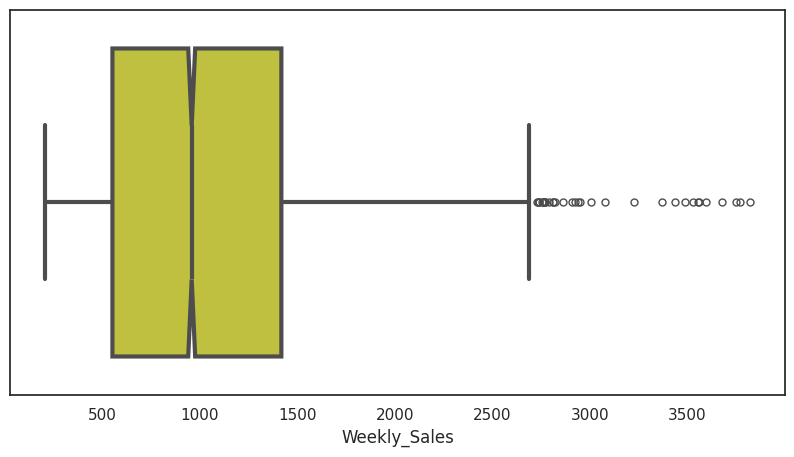

In [385]:
fig = plt.figure(figsize=(10, 5))
ax = fig.gca()

ax = sns.boxplot(data_train.Weekly_Sales, orient='h', fliersize=5,
                 linewidth=3, notch=True, saturation=0.5, ax=ax, color = 'yellow')
plt.show()

In [386]:
# Lets consider 3,000,000 as upper limit
data_train[data_train.Weekly_Sales>3000].shape

(14, 76)

In [387]:
# there is only 14 outliers. Lets drop it and proceed.
data_train=data_train[data_train.Weekly_Sales<3000]

# <p style="background-color:coral;font-family:newtimeroman;color:white;font-size:150%;text-align:center;border-radius:20px 60px;">Improve and Evaluate Model</p>


<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:220%;border-radius:20px 60px;"> Feature Selection </p>


We have seen the models are giving a terrible crossvalidation score. So lets tune our model. for that first we should figure out what all should we use as our features. For this a feature selection would be the best thing. So lets use Lasso Feature Selection and see how our model works with that.

In [388]:
predictors=[col for col in data.columns if col not in ['Weekly_Sales','Sqrt_Sales','lnSales','Date']] # Date

predictors=[col for col in predictors if 'Month' not in col]
predictors=[col for col in predictors if 'Week' not in col]
predictors=[col for col in predictors if 'Year' not in col]


<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:220%;border-radius:20px 60px;"> Test-Train Split such that Test data is last 90 days data (future 3 months prediction) </p>

In [389]:
X_train = data_train[predictors]
y_train = data_train.Weekly_Sales.values

X_test = data_test[predictors]
y_test = data_test.Weekly_Sales.values

In [390]:
X_train_s=ss.fit_transform(X_train)
X_test_s=ss.fit_transform(X_test)


<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:220%;border-radius:20px 60px;"> LGBM Regressor </p>

**LightGBM is a relatively new algorithm. It is a gradient boosting framework that uses tree based learning algorithm.**


**Light GBM can handle the large size of data and takes lower memory to run. Another reason of why Light GBM is popular is because it focuses on accuracy of results. LGBM also supports GPU learning and thus data scientists are widely using LGBM for data science application development.**

In [391]:
lgbm_features = lgb.LGBMRegressor()

In [392]:
X_train.replace({False: 0, True: 1}, inplace=True)

In [393]:
X_train

,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,...,Store_36,Store_37,Store_38,Store_39,Store_40,Store_41,Store_42,Store_43,Store_44,Store_45
4230,42988.0,78.87,3.546,477.4544,2674.1796,21.1024,881.3160,1899.3088,215.514829,7.852,...,0,0,0,0,0,0,0,0,0,0
5019,39910.0,77.53,2.805,310.3896,344.3576,43.7824,1264.3248,1403.1416,209.118536,8.464,...,1,0,0,0,0,0,0,0,0,0
1273,125833.0,86.41,3.407,1042.7300,8.0000,1.6600,1129.2000,2929.4300,225.697078,5.277,...,0,0,0,0,0,0,0,0,0,0
5791,196321.0,62.30,3.697,5997.3564,5195.7300,192.0716,1807.0540,5001.6932,192.903476,6.934,...,0,0,0,0,0,1,0,0,0,0
5795,196321.0,68.18,3.532,5698.6408,5162.5156,184.9260,2096.1224,4899.2636,193.312548,6.901,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2293,93188.0,29.71,2.733,6386.5024,4395.9140,736.9708,3256.6792,3688.7772,126.604286,6.548,...,0,0,0,0,0,0,0,0,0,0
5886,39690.0,91.80,2.971,414.1624,612.3544,17.0608,1358.7332,1222.2592,126.149806,9.199,...,0,0,0,0,0,0,1,0,0,0
3019,119557.0,65.64,2.906,8393.4604,3093.5512,139.0932,3357.7792,4984.0364,136.148910,8.348,...,0,0,0,0,0,0,0,0,0,0
5767,196321.0,25.19,2.829,7770.2264,7936.4480,3390.3012,5104.0140,4968.1716,191.255700,7.508,...,0,0,0,0,0,1,0,0,0,0


In [394]:
lgbm_features.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000891 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2426
[LightGBM] [Info] Number of data points in the train set: 5836, number of used features: 57
[LightGBM] [Info] Start training from score 1042.925827


LGBMRegressor()

In [395]:
predict=lgbm_features.predict(X_test_s)
predict.shape

(585,)

In [396]:
lgb_score=lgbm_features.score(X_test_s,y_test)

In [397]:
X_train.columns

Index(['Size', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
       'IsHoliday', 'Type_A', 'Type_B', 'Store_2', 'Store_3', 'Store_4',
       'Store_5', 'Store_6', 'Store_7', 'Store_8', 'Store_9', 'Store_10',
       'Store_11', 'Store_12', 'Store_13', 'Store_14', 'Store_15', 'Store_16',
       'Store_17', 'Store_18', 'Store_19', 'Store_20', 'Store_21', 'Store_22',
       'Store_23', 'Store_24', 'Store_25', 'Store_26', 'Store_27', 'Store_28',
       'Store_29', 'Store_30', 'Store_31', 'Store_32', 'Store_33', 'Store_34',
       'Store_35', 'Store_36', 'Store_37', 'Store_38', 'Store_39', 'Store_40',
       'Store_41', 'Store_42', 'Store_43', 'Store_44', 'Store_45'],
      dtype='object')

In [398]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgbm_features.feature_importances_
}).sort_values('importance', ascending=False)

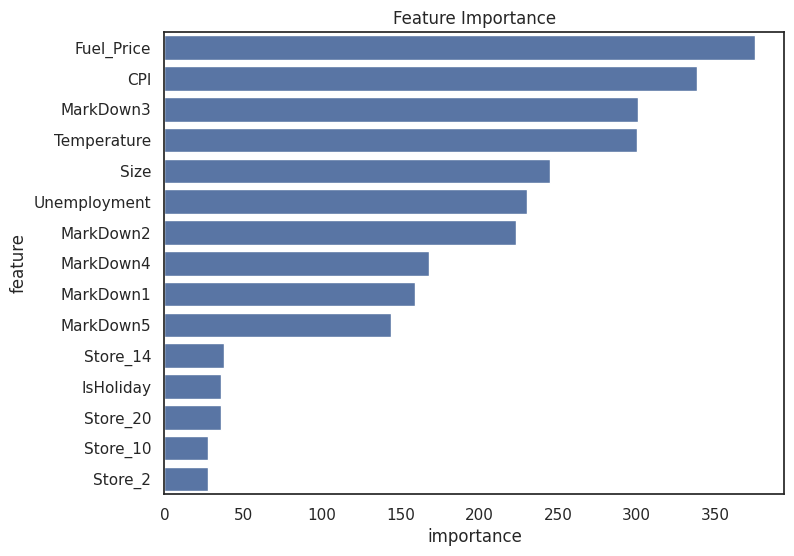

In [399]:
plt.figure(figsize=(8,6))
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(15), x='importance', y='feature');

#### Clearly we have the top features listed above.

**Top five :**
    
    Fuel_Price
    CPI
    Markdown3
    Temperature
    Size
    

## Note :
    
 1. sklearn’s algorithm cheat sheet suggests to try Lasso, ElasticNet, or Ridge when our data-set is smaller than 100k rows. Else, try GDRegressor.

 2. Lasso and ElasticNet tend to give sparse weights (most zeros), because the l1 regularization cares equally about driving down big weights to small weights, or driving small weights to zeros. If you have a lot of predictors (features), and you suspect that not all of them are that important, Lasso and ElasticNet may be really good idea to start with.

***As both the above conditions satisfy, we should go with Lasso regressor and see the performance.***

*If it's not good enough we can always switch back to LGBM/XGB etc.*


<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:220%;border-radius:20px 60px;"> Lasso Feature Selection </p>

Test- Train Split such that Test data is last 90 days data (Like a furture 3 months prediction)

#### LASSO is a regression analysis method that performs both variable selection and regularization in order to enhance the prediction accuracy and interpretability of the statistical model it produces.

*The basic idea is to penalize the model coefficients such that they don’t grow too big and overfit the data. Using LASSO regression, we are essentially eliminating the higher-order terms in the more complex models.*

**So, LASSO regression is similar to Linear Regression, but with a penalization coefficient at the end of the formula, eliminating the least important terms.**


In [400]:
lasso_cv = LassoCV(n_alphas=1000,max_iter=2000, cv=10, verbose=1)
lasso_cv.fit(X_train_s, y_train)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

LassoCV(cv=10, max_iter=2000, n_alphas=1000, verbose=1)

In [401]:
# Put the features and coefs into a dataframe
# sort by magnitude
lasso_feat = pd.DataFrame(dict(feature=X_train.columns, coef=lasso_cv.coef_, abscoef=np.abs(lasso_cv.coef_)))
lasso_feat.sort_values('abscoef', inplace=True, ascending=False)
# main_features
lasso_feat[lasso_feat.coef != 0.]

,feature,coef,abscoef
0,Size,347.440079,347.440079
11,Type_A,172.384215,172.384215
21,Store_10,131.966692,131.966692
19,Store_8,-98.376268,98.376268
51,Store_40,-92.706010,92.706010
43,Store_32,-89.647948,89.647948
44,Store_33,-85.179793,85.179793
20,Store_9,-77.209609,77.209609
52,Store_41,-77.163473,77.163473
45,Store_34,-75.254886,75.254886


In [402]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgbm_features.feature_importances_
}).sort_values('importance', ascending=False)

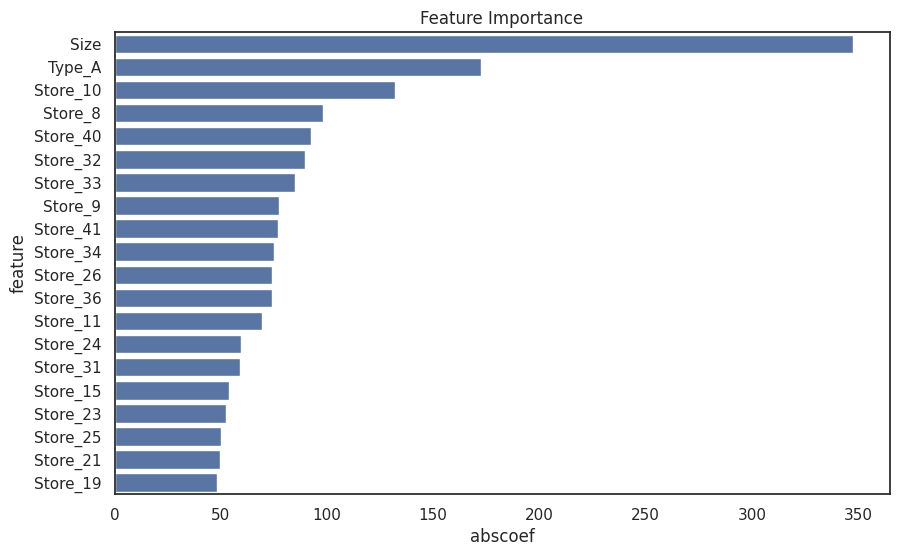

In [403]:
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=lasso_feat.head(20), x='abscoef', y='feature');

**The list of features that are seleted and their magnitude of effect on weekly sales can be seen above (remember the target is scaled down)**

*We will set the predictors that we got from Lasso as our actual predictors and use in further models*

In [404]:
actual_predictors=lasso_feat[lasso_feat.coef != 0.].feature.values

In [405]:
# Lets see the best alpha score
lasso_cv.alpha_

#best alpha value is 0.45384197291954748 which could be used later to run model

0.4538419729195478

In [406]:
# We will assign the best alpha score and according to that we will train and test our model
best_lasso = Lasso(alpha=lasso_cv.alpha_)
best_lasso.fit(X_train_s, y_train)

Lasso(alpha=0.4538419729195478)

In [407]:
lasso_scores = cross_val_score(best_lasso, X_train_s, y_train, cv=10)

print (lasso_scores)
print (np.mean(lasso_scores))

[0.93823147 0.93737107 0.93119327 0.91596283 0.91710949 0.93612665
 0.94648367 0.9429067  0.93809464 0.93224976]
0.9335729518402343


In [408]:
def wmae_test(test, pred): # WMAE for test
    weights = X_test['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
    error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
    return error

#### Thats great. getting a cross validated score of .933 is good. Now lets use this to predict our last 90 days data which the model don't know about. So if this works well in this test data give a good score and residual is small or comparable to train data we can assume its not overfitting

In [409]:
lasso_yhat=best_lasso.predict(X_test_s)
lasso_score=best_lasso.score(X_test_s, y_test)
print("R2: ",lasso_score)
lasso_adj_r2 = 1 - (len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)*(1-lasso_score)
print("Adjusted R2: ",lasso_adj_r2)

R2:  0.9602241138737961
Adjusted R2:  0.9559219781827266


In [410]:
wmae_score_lasso=wmae_test(lasso_yhat.ravel(),y_test.ravel())
wmae_score_lasso

69.68348662839729

In [411]:
# converting the residuals into the actual dimenssion

train_resids = y_train*1000 - best_lasso.predict(X_train_s)*1000
test_resids = y_test*1000 - lasso_yhat*1000
lasso_residue=np.abs(test_resids).sum()
# Let me look at the actual Residuals.
print("Train Residual",np.abs(train_resids).sum())
print("Test Residual",lasso_residue)
print("Residual ratio of Test to Train",np.abs(test_resids).sum()/np.abs(train_resids).sum())
# The Residual looks quite big. But this can be because our base values ( Weekly Sales) are quite big
# and in terms of millions

Train Residual 500899948.58931696
Test Residual 39751906.32790464
Residual ratio of Test to Train 0.07936097106789054


The residuals seems to be in same ratio,Train dataset have a higher ratio because its compartively bigger in size.


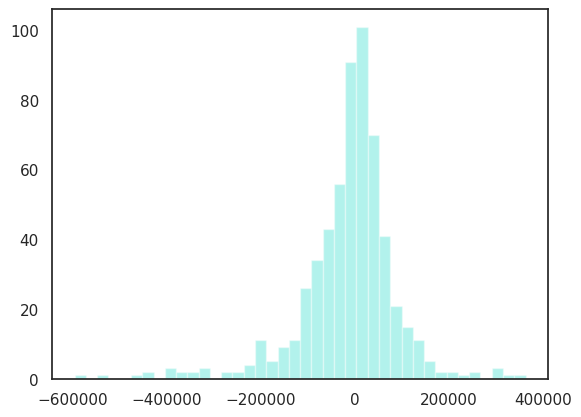

In [412]:
sns.distplot(test_resids, kde=False, bins=40, color = 'turquoise')
plt.show()

# The residuals looks ok and almost like a normal distribution

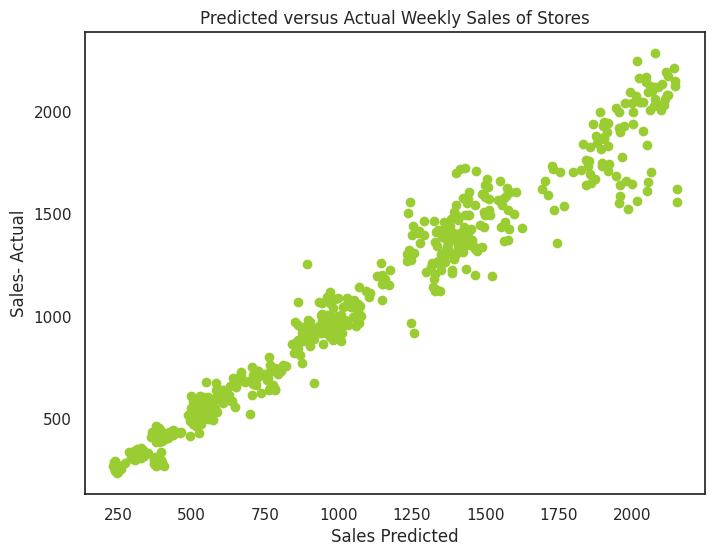

In [413]:
fig = plt.subplots(figsize=(8,6))
plt.scatter(lasso_yhat,y_test, c='yellowgreen')
plt.xlabel('Sales Predicted')
plt.ylabel('Sales- Actual')
plt.title('Predicted versus Actual Weekly Sales of Stores')
#plt.savefig('./images/Actual_vs_Predicted_Sales.png')
plt.show()

Lasso Model works well giving me a good adjusted R2 and low residual. The residual is also form a normal distribution whcih shows the model is doing not much wierd things. **The actual vs Predicted Sales looks promising**


<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:220%;border-radius:20px 60px;"> Setting the predictors from Lasso and Train Test split for further use </p>

We will set my predictors to the ones that are selected from Lasso and will use this predictors and Train Test split for further use in all my models.

In [414]:
X_train = X_train[actual_predictors]
X_test = X_test[actual_predictors]

X_train_s=ss.fit_transform(X_train)
X_test_s=ss.fit_transform(X_test)


In [415]:
y_test

array([1631.13579, 1592.40997, 1597.86805, 1494.12238, 1582.0834 ,
       1661.76733, 1517.42887, 1506.12606, 1437.05926, 1670.78597,
       1573.07281, 1508.06877, 1493.65974, 1946.10464, 1866.71996,
       1928.01601, 1876.78815, 1947.0833 , 1898.77707, 1814.80663,
       1829.41567, 1746.47056, 1998.32104, 1900.74513, 1847.99041,
       1834.45835,  419.99029,  391.8116 ,  394.91883,  412.44967,
        408.83873,  408.22973,  407.58916,  414.39209,  389.81302,
        443.55765,  410.80439,  424.51308,  405.4327 , 2174.51413,
       2193.36769, 2283.5403 , 2125.24168, 2081.18135, 2125.10472,
       2117.8546 , 2119.43853, 2027.62023, 2209.83543, 2133.02607,
       2097.26685, 2149.59446,  324.19517,  306.7597 ,  314.01418,
        320.83136,  344.64201,  350.64891,  299.80067,  307.30676,
        310.14168,  343.04829,  325.34541,  313.35815,  319.55077,
       1627.27493, 1588.38073, 1543.04952, 1501.09549, 1577.43981,
       1608.07701, 1375.16686, 1425.60365, 1369.13146, 1518.17



# <p style="background-color:coral;font-family:newtimeroman;color:white;font-size:150%;text-align:center;border-radius:20px 60px;">Final Model selection & Implementation</p>


We have already implemented Lasso Regressor and would be looking through and implementing different model of regressors in this part. This is more or a trail and error method with the know models that could do better in Regressions



#### Decision Trees are likely to overfit and result in over learning.
So we will go for Random Forest Regressor which is a ensemble method of decision tree and check how it works.


<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:220%;border-radius:20px 60px;"> Random Forest Regressor </p>

In [416]:
rfr=RandomForestRegressor(n_estimators=100, max_depth=None, max_features='auto')

In [417]:
# Fit and crossvalidate on train data
rfr.fit(X_train_s, y_train)
rfr_scores = cross_val_score(rfr, X_train_s, y_train, cv=10)
np.mean(rfr_scores)

0.9488933783967898

In [418]:
rfr_yhat = rfr.predict(X_test_s)
rfr_score=rfr.score(X_test_s, y_test)

print("R2: ",rfr_score)
rfr_adj_r2 = 1 - (len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)*(1-rfr_score)
print("Adjusted R2: ",rfr_adj_r2)

R2:  0.7884687833511027
Adjusted R2:  0.7673554980735292


In [419]:
wmae_score_rf=wmae_test(rfr_yhat.ravel(),y_test.ravel())
wmae_score_rf

169.57683796183005

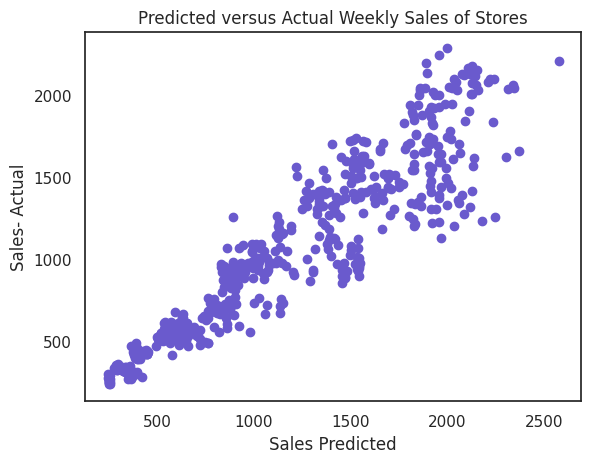

In [420]:
plt.scatter(rfr_yhat, y_test, color='slateblue')
plt.xlabel('Sales Predicted')
plt.ylabel('Sales- Actual')
plt.title('Predicted versus Actual Weekly Sales of Stores')
plt.show()

In [421]:
train_resids = y_train*1000 - rfr.predict(X_train_s)*1000
test_resids = y_test*1000 - rfr_yhat*1000
rfr_residue=np.abs(test_resids).sum()
# Let me look at the actual Residuals.
print("Train Residual",np.abs(train_resids).sum())
print("Test Residual",rfr_residue)
print("Residual ratio of Test to Train",np.abs(test_resids).sum()/np.abs(train_resids).sum())

Train Residual 150370737.7183999
Test Residual 92402605.19119997
Residual ratio of Test to Train 0.6144985825915333


The cross validated score on train data seems to be very good but test score is not that upto mark which says this might not be the best model. Even when we look into residuals its big compared to the size of train data. So we will move on to another model and see how it would be.


<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:220%;border-radius:20px 60px;"> GradientBoostingRegressor</p>

In [422]:
gb = GradientBoostingRegressor(n_estimators=100,max_depth=10,learning_rate=0.1)

In [423]:
gb.fit(X_train_s, y_train)
gb_scores = cross_val_score(gb, X_train_s, y_train, cv=6)
np.mean(gb_scores)

0.9508353412395779

In [424]:
y_test=y_test.reshape(-1,1)

In [425]:
y_test.shape

(585, 1)

In [426]:
gb_yhat=gb.predict(X_test_s)

In [427]:
gb_yhat=gb_yhat.reshape(-1,1)

In [428]:
gb_yhat.shape

(585, 1)

In [429]:
def wmae_test(test, pred): # WMAE for test
    weights = X_test['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
    error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
    return error

In [430]:
gb_yhat_flat = gb_yhat.ravel()
y_test_flat = y_test.ravel()

# Calcul du WMAE
wmae_score_xgb = wmae_test(gb_yhat_flat, y_test_flat)
print("WMAE score:", wmae_score_xgb)

WMAE score: 172.08335993307685


In [431]:
gb_yhat=gb.predict(X_test_s)
gb_score=gb.score(X_test_s,y_test)

print("R2: ",gb_score)
gb_adj_r2 = 1 - (len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)*(1-gb_score)
print("Adjusted R2: ",gb_adj_r2)

R2:  0.7699049437086545
Adjusted R2:  0.7469387704818347


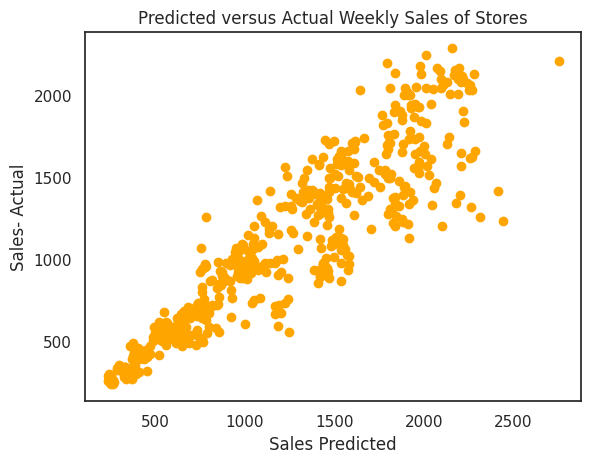

In [432]:
plt.scatter(gb_yhat, y_test, c='orange')
plt.xlabel('Sales Predicted')
plt.ylabel('Sales- Actual')
plt.title('Predicted versus Actual Weekly Sales of Stores')

plt.show()

In [433]:
train_resids = y_train*1000 - gb.predict(X_train_s)*1000
test_resids = y_test*1000 - gb_yhat*1000
gb_residue=np.abs(test_resids).sum()
# Let me look at the actual Residuals.
print("Train Residual",np.abs(train_resids).sum())
print("Test Residual",gb_residue)
print("Residual ratio of Test to Train",np.abs(test_resids).sum()/np.abs(train_resids).sum())

Train Residual 70612589.50101234
Test Residual 221965812506.06287
Residual ratio of Test to Train 3143.431137062048


Here we can see the model is learning a lot from train data and gives a cross validated score of .95 where as in the test data the score is .79 which is too low compared to train data. Its not a good sign.
I will check the residuals and here the test residual is higher than train even though the train dataset is much bigger.

**This again is a clear case of over fitting and we wont use this model further.**

#### So out of all models the best comes with Lasso regression

In [434]:
Residual_graph=pd.DataFrame()
Residual_graph["Store"]=range(1,46)
Residual_graph['actual_y']=0
Residual_graph['predicted_lasso_y']=0

count=0
for x in y_test:
    count+=1
    Residual_graph['actual_y'][count%45]+=x

count=0
for x in lasso_yhat:
    count+=1
    Residual_graph['predicted_lasso_y'][count%45]+=x

Residual_graph["actual_y"]=Residual_graph["actual_y"]/13
Residual_graph["predicted_lasso_y"]=Residual_graph["predicted_lasso_y"]/13

Residual_graph["Residual_lasso"]=np.abs(Residual_graph["actual_y"] - Residual_graph["predicted_lasso_y"])
Residual_graph["Residual_lasso_percentage"]=(Residual_graph["Residual_lasso"]/Residual_graph["actual_y"])*100

In [435]:
# Setting the size of bubble according to the percentage change in prediction
s=Residual_graph.Residual_lasso_percentage.values
s=s*100

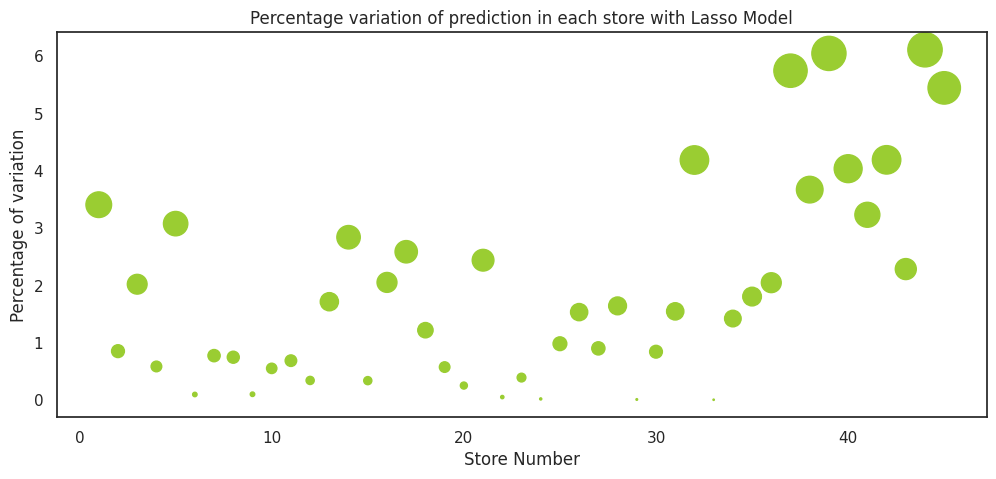

In [436]:
fig = plt.subplots(figsize=(12,5))
plt.scatter(Residual_graph.Store, Residual_graph.Residual_lasso_percentage, s=s, color = 'yellowgreen')
plt.xlabel('Store Number')
plt.ylabel('Percentage of variation')
plt.title('Percentage variation of prediction in each store with Lasso Model')
#plt.savefig('./images/percentage_prediction_variation.png')
plt.show()

#### This plot shows the variation of prediction or the percentage residual change for each store.

Here the bigger the bubble is the higher the variation in prediction. So we can see that there are **around 4 stores which have more than 5% variation in prediction.**

**The smaller the bubble the better it is** since that shows how predictions are close to actual values. This can be used to futher tune our model because some other model might be doing good with the store which is doing bad in this model.


In [437]:
# Create a dataframe to compare different models
Score=pd.DataFrame()
Score["Model_Name"]=('Lasso','RandomForest','GradientBoosting')
Score["Test_Score"]=(lasso_score,rfr_score,gb_score)


In [438]:
def wmae_test(test, pred): # WMAE for test
    weights = X_test['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
    error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
    return error


# <p style="background-color:coral;font-family:newtimeroman;color:white;font-size:150%;text-align:center;border-radius:20px 60px;">Insights & Conclusion</p>

<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:220%;border-radius:20px 60px;"> Interpret findings and relate to goals/criteria</p>


 - From the modeling we have found **Lasso method works the best by itself with an accuracy of .93.**

 - The **rain forest regressor  works good**. We have plotted a percentage residual change with bubbles to check how good is the prediction for each store.

 - This could be a good method to look into each store and see which stores are doing good with this model and which are not.

 - Similarly we can find model that works better for that particular store and make an ensemble model with prediction power for each store assigned to each model.

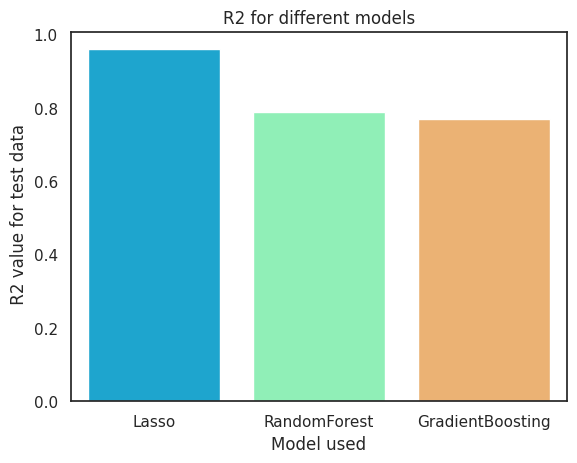

In [439]:
# Checking how the Type of the store have effect on the sales.
sns.barplot(x="Model_Name", y="Test_Score", data=Score,orient='v', palette='rainbow')
plt.xlabel('Model used')
plt.ylabel(' R2 value for test data')
plt.title('R2 for different models')
#plt.savefig('./images/R2_for_different_models.png')
plt.show()


In [440]:
# Create a dataframe to compare different models
Score2=pd.DataFrame()
Score2["Model_Name"]=('Lasso','RandomForest','GradientBoosting')
Score2["wmae_score"]=(wmae_score_lasso,wmae_score_rf,wmae_score_xgb)

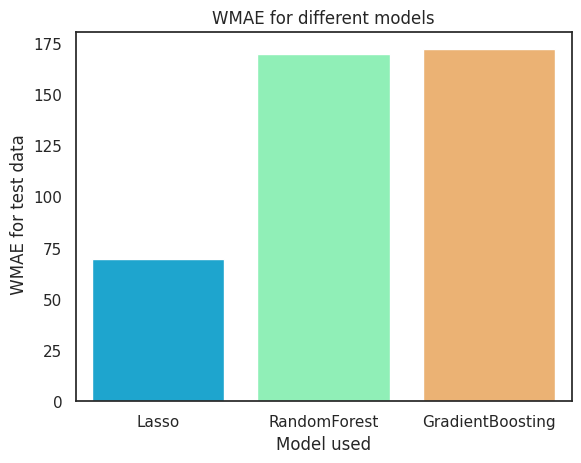

In [441]:
sns.barplot(x="Model_Name", y="wmae_score", data=Score2,orient='v', palette='rainbow')
plt.xlabel('Model used')
plt.ylabel(' WMAE for test data')
plt.title('WMAE for different models')
#plt.savefig('./images/R2_for_different_models.png')
plt.show()


**Lasso Regressor gives the best prediction and outperforms all other models as indicated by the R2 values.**

In [442]:
df_liste = pd.DataFrame({'sales_forec':lasso_yhat,'Date2':data_test['Date']})
data_test2.reset_index(drop=True, inplace=True)
df_liste.reset_index(drop=True, inplace=True)

# Fusionner les deux ensembles de données en utilisant les index
resultat2 = pd.merge(data_test2, df_liste, left_on='Date', right_on='Date2')


resultat2.columns

Index(['Store', 'Date', 'Type', 'Size', 'Temperature', 'Fuel_Price',
       'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI',
       'Unemployment', 'IsHoliday', 'Day', 'Month', 'Year', 'Week',
       'sales_forec_x', 'sales_forec_y', 'Date2'],
      dtype='object')

##Saving the results

In [443]:
# Fusionner les DataFrames sur la colonne "Date"
data_test2['sales_forec'] = df_liste['sales_forec']


In [444]:
data_test2.to_csv('resultat2.csv', index=False)  # Save the DataFrame to a CSV file without index

### Conclusion

*Finally, after building multiple models to predict the weekly sales of 45 stores, we got the best accuracy of around 94% of accuracy for 3 months(90 Days).*

Out of all the models, we select the **Lasso Regressor as our predictive Model since due to it's highest prediction accuracy  with the lowest residual(error).**



<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:220%;border-radius:20px 60px;"> Recommendation and Benefits</p>

1. **Size of the store is the highest contributing predictor in the model out of all.**
2. **Each store has a unique prediction power**. They can be separately analyzed to get prediction for each individual store
3. The **Sales are very high during November and December and go down in January**. So its better to employee more staff as casual employee in November and December and encourage permanent staff to take leaves during January.
4. The predicted sales data can be used to analyse the sales pattern and accordingly **adjust the staff in the store.**
5. When we implement the project to department level it helps to plan the inventory and staff from a centralised station to every store, which will further help in **better planning and cost cutting** for **inventory management, supply chain management and human resource.**
6. The **low selling stores should look forward to increasing their size and capacity to store more items and consumer products.**
7. **Special discount coupons can be distributed during low selling periods to attract more customers**

8. Sales are likely to fluctuate during holidays. **Special offers can be given during festive season** accompanied with suitable marketing to keep the sales high during holidays as well


<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:220%;border-radius:20px 60px;"> Next steps</p>

**The Next steps would be :-**

1. To check into the store that have poor prediction and check deep what makes those bad.
2. To further improve the predictive model using the ensembling method to combine models and come with better model.
3. Take the data to Department level and to predict the Department level sales which would help to solve the inventory management issues and supply chain management.

![](https://businessfirstfamily.com/wp-content/uploads/2016/01/sales-forecasting-methods-graphs.jpg)

# <p style="background-color:white;font-family:newtimeroman;color:turquoise;font-size:150%;text-align:center;border-radius:20px 60px;">REFERENCES</p>

https://medium.datadriveninvestor.com/walmart-sales-data-analysis-sales-prediction-using-multiple-linear-regression-in-r-programming-adb14afd56fb

https://prezi.com/vpvakz73fjjp/walmart-sales-analysis/

https://www.kaggle.com/code/maxdiazbattan/wallmart-sales-eda-feat-eng-future-update

https://www.kaggle.com/code/avelinocaio/walmart-store-sales-forecasting

https://www.kaggle.com/code/yepp2411/walmart-prediction-1-eda-with-time-and-space